In [54]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy import stats as sp_stats
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score
from data_loading import read_channels_of_dataset, get_cores
from PIL import Image
from tqdm import tqdm

In [13]:
sns.set_style("white")
sns.set_context("talk")
mpl.rcParams['figure.dpi'] = 600
plt.rcParams.update({'font.size': 18})

# Config

In [ ]:
data_root_directory = '/sise/assafzar-group/assafzar/metalspy/TNBC-metals-data'
channels = read_channels_of_dataset(data_root_directory)
cores_dataset = get_cores(data_root_directory)

.\la-icp-ms\aq_cores_2_FFPE.h5: 100%|██████████| 47/47 [00:01<00:00, 36.73it/s]


Excluded cores
['Leap144', 'Leap145', 'Leap146', 'Leap142', 'Leap143', 'Leap147', 'Leap148', 'Leap149', 'Leap150', 'Leap151', 'Leap010', 'Leap117', 'Leap137', 'Leap114', 'Leap140']


In [ ]:
experiments_results_dir = '/sise/assafzar-group/assafzar/metalspy/TNBC-metals-model'

# Baseline pipeline vs excluding hotspots

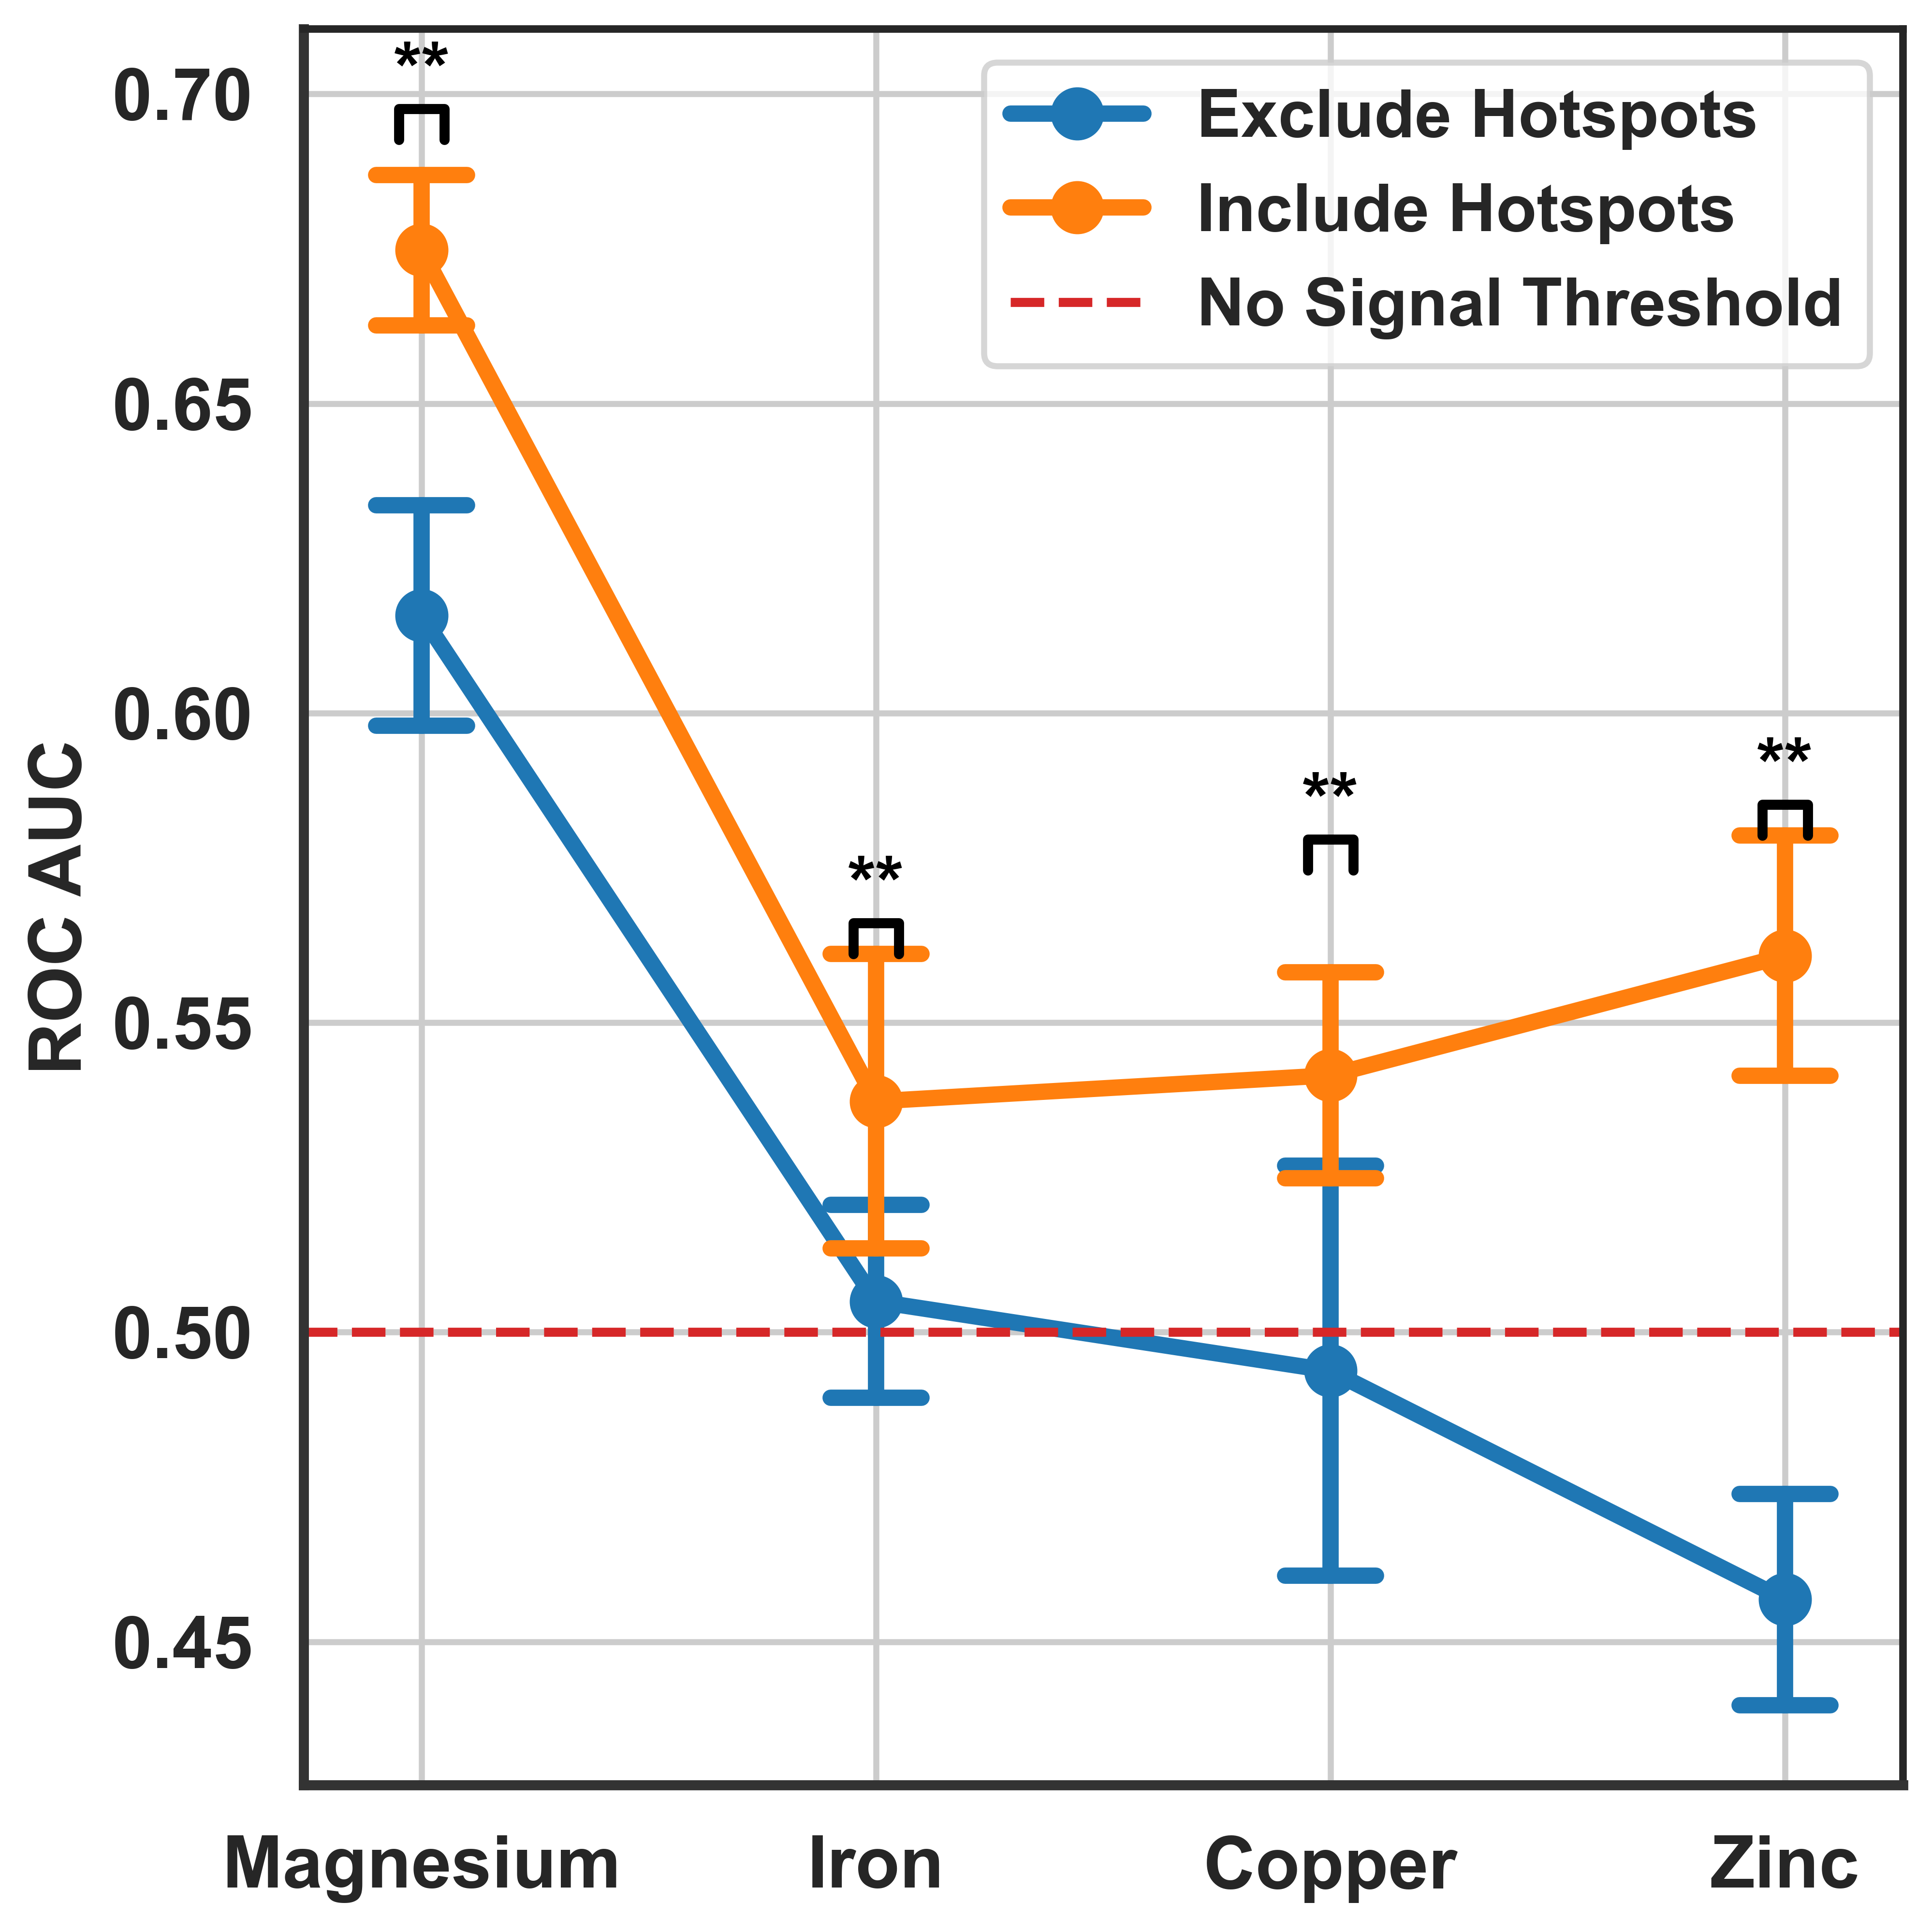

In [49]:
def analyze():
    model_seeds = [
        11, 19, 21, 22, 31, 36, 38, 54, 67, 82, 85, 88, 92, 94, 96, 112, 116, 140, 148, 156,
        161, 177, 178, 212, 223, 225, 240, 242, 249, 276, 289, 293, 294, 300, 306, 309, 311,
        320, 338, 342, 349, 358, 372, 373, 374, 382, 395, 418, 440, 444, 445, 465, 479, 480,
        492, 494, 526, 567, 569, 586, 596, 600, 602, 606, 620, 633, 637, 641, 645, 647, 664,
        689, 697, 708, 748, 753, 777, 794, 804, 812, 828, 831, 843, 858, 861, 875, 889, 891,
        894, 897, 904, 917, 947, 962, 982, 983, 985, 987, 990, 998
    ]
    hist_size = 20
    percentile = 0.8
    
    stats = {
        'is-hotspots': [],
        'auc': [],
        'metal': [],
    }
    for metal in ['magnesium', 'iron', 'copper', 'zinc']:
        experiment_path = os.path.join(
            experiments_results_dir, 'hotspots_excluded_cv_train_eval', 
            f'histogram-size-{hist_size}', f'percentile-{percentile}', 'all-cores'
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        stats['auc'] += aucs
        stats['is-hotspots'] += ['Exclude Hotspots'] * len(aucs)
        stats['metal'] += [metal.title()] * len(aucs)
        
        experiment_path = os.path.join(
            experiments_results_dir, 'baseline_cv_train_eval',
            f'histogram-size-{hist_size}', f'p-{percentile}', 'all-cores'
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        stats['auc'] += aucs
        stats['is-hotspots'] += ['Include Hotspots'] * len(aucs)
        stats['metal'] += [metal.title()] * len(aucs)
    stats = pd.DataFrame(stats)

    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    default_palette = sns.color_palette()
    sns.pointplot(
        data=stats,
        x='metal',
        y='auc',
        hue='is-hotspots',
        capsize=0.2,
        errorbar='sd',
        ax=ax,
    )
    def significance_bar(start, end, y, display_label):
        size = (ax.get_yticks()[-1] - ax.get_yticks()[-2]) / 10
        h, col = size, 'k'
        ax.plot([start, start, end, end], [y, y+h, y+h, y], lw=2.5, c=col)
        ax.text((start+end)*.5, y+h, display_label, ha='center', va='bottom', color=col, weight='bold')
    
    for i, metal in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
        metal_df = stats[stats['metal'] == metal.title()]
        is_hotspots = metal_df['is-hotspots'] == 'Include Hotspots'
        y = np.max([metal_df.loc[is_hotspots, 'auc'].mean(), metal_df.loc[~is_hotspots, 'auc'].mean()]) + np.max([metal_df.loc[is_hotspots, 'auc'].std(), metal_df.loc[~is_hotspots, 'auc'].std()])
        _, pval = sp_stats.ttest_ind(metal_df.loc[is_hotspots, 'auc'], metal_df.loc[~is_hotspots, 'auc']) 
        if pval < 0.05:
            significance_bar(i-0.05, i+0.05, y, '**')
        else:
            significance_bar(i-0.05, i+0.05, y, 'NS')
    ax.grid()
    ax.axhline(y = 0.5, color = default_palette[3], linestyle = '--', label='No Signal Threshold') 
    ax.set_ylabel('ROC AUC', fontdict={'weight': 'bold'})
    ax.set_xlabel('')
    ax.legend(prop={'weight':'bold'})
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    fig.tight_layout()
    plt.show()
analyze()

# Excluded cores - changing percentile

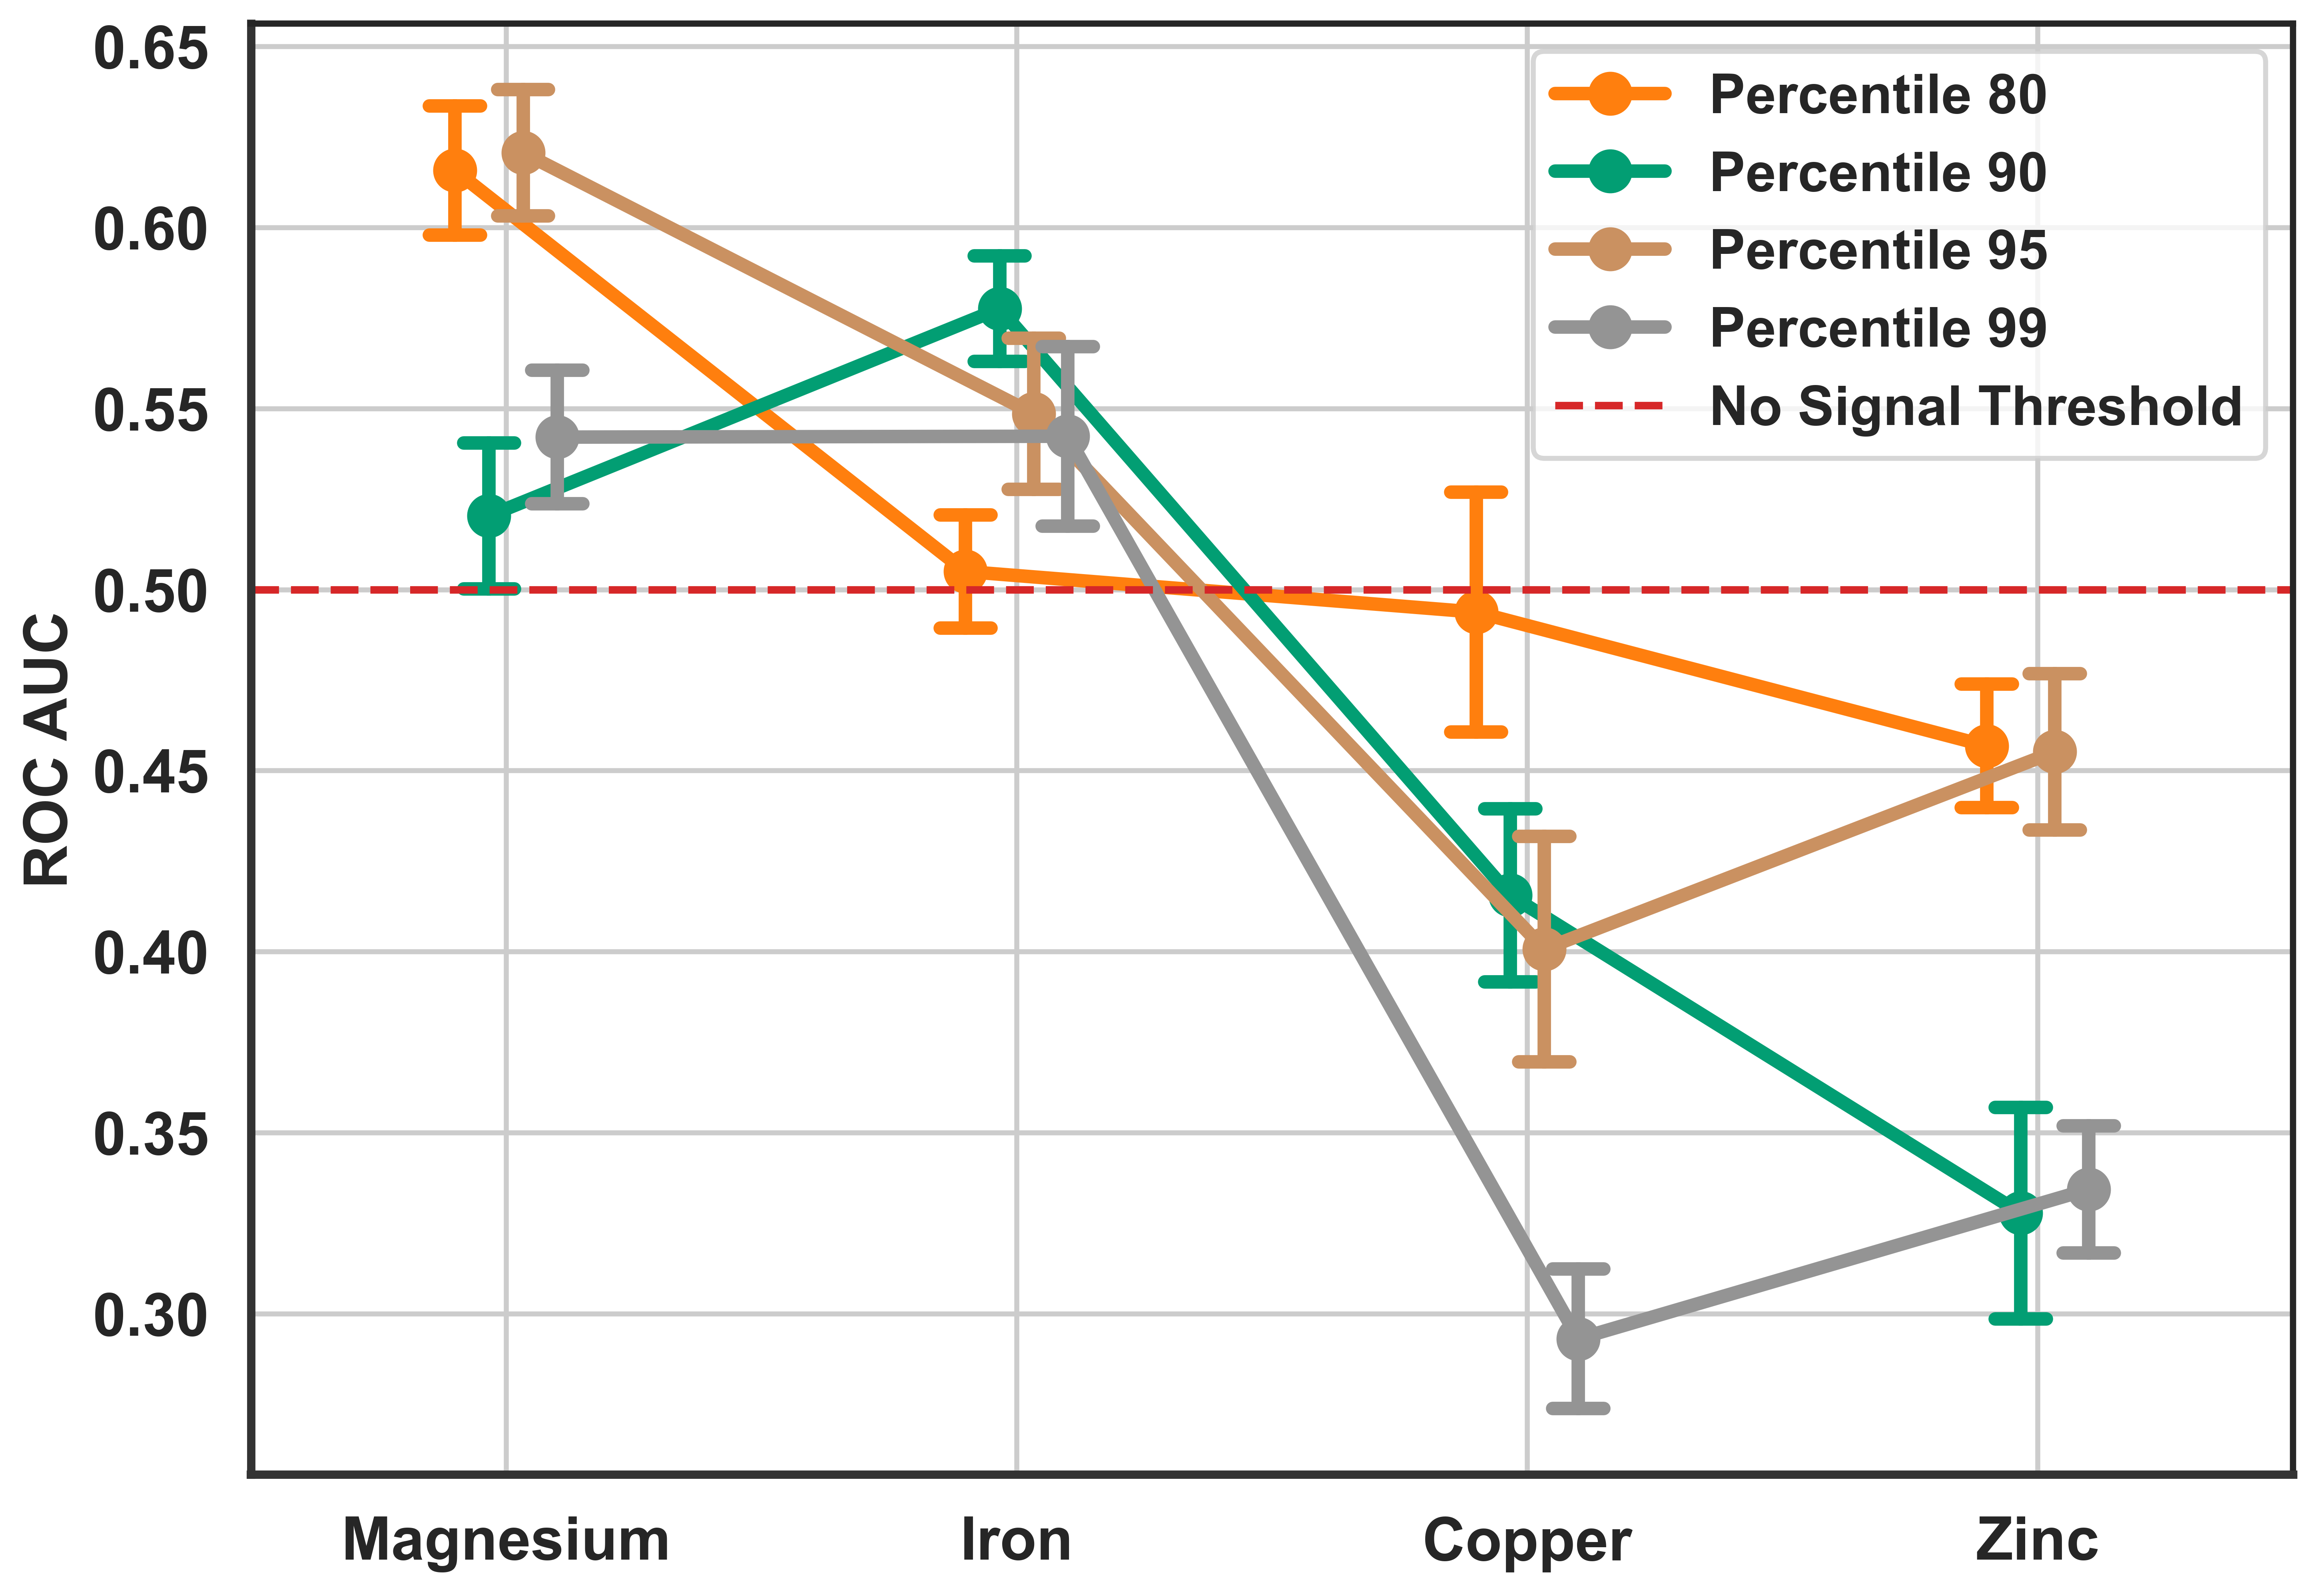

In [50]:
def analyze():
    model_seeds = [
        11, 19, 21, 22, 31, 36, 38, 54, 67, 82, 85, 88, 92, 94, 96, 112, 116, 140, 148, 156,
        161, 177, 178, 212, 223, 225, 240, 242, 249, 276, 289, 293, 294, 300, 306, 309, 311,
        320, 338, 342, 349, 358, 372, 373, 374, 382, 395, 418, 440, 444, 445, 465, 479, 480,
        492, 494, 526, 567, 569, 586, 596, 600, 602, 606, 620, 633, 637, 641, 645, 647, 664,
        689, 697, 708, 748, 753, 777, 794, 804, 812, 828, 831, 843, 858, 861, 875, 889, 891,
        894, 897, 904, 917, 947, 962, 982, 983, 985, 987, 990, 998
    ]
    hist_size = 20
    
    stats = {
        'metal': [],
        'percentile': [],
        'is-hotspots': [],
        'auc': [],
    }
    for metal in ['magnesium', 'iron', 'copper', 'zinc']:
        percentiles = [
            0.8,
            0.9,
            0.95,
            0.99,
        ]
        
        for percentile in percentiles:
            experiment_path = os.path.join(
                experiments_results_dir, 'hotspots_excluded_cv_train_eval', 
                f'histogram-size-{hist_size}', f'percentile-{percentile}', 'all-cores'
            )
            aucs = []
            for model_seed in model_seeds:
                csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
                if not os.path.exists(csv_path):
                    continue  # Skip if file does not exist
                df = pd.read_csv(csv_path)
                y_true = df['ground-truth'].astype('int32')
                y_scores = df['prediction-proba-1']
                auc = roc_auc_score(y_true, y_scores)
                aucs.append(auc)
            stats['auc'] += aucs
            stats['metal'] += [metal.title()] * len(aucs)
            stats['percentile'] += [f'Percentile {int(percentile * 100)}'] * len(aucs)
            stats['is-hotspots'] += ['Exclude Hotspots'] * len(aucs)
            
    stats = pd.DataFrame(stats)

    default_palette = sns.color_palette() 
    colorblind_palette = sns.color_palette('colorblind')
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    sns.pointplot(
        data=stats,
        x='metal',
        y='auc',
        hue='percentile',
        capsize=0.1,
        dodge=0.2,
        errorbar='sd',
        palette=[default_palette[1], colorblind_palette[2], colorblind_palette[-5], colorblind_palette[-3]],
        ax=ax,
    )
    ax.grid()
    ax.axhline(y = 0.5, color = default_palette[3], linestyle = '--', label='No Signal Threshold') 
    ax.set_ylabel('ROC AUC', fontdict={'weight': 'bold'})
    ax.set_xlabel('')
    ax.legend(prop={'weight':'bold'})
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    fig.tight_layout()
    plt.show()
analyze()

# Baseline vs with positional encoding

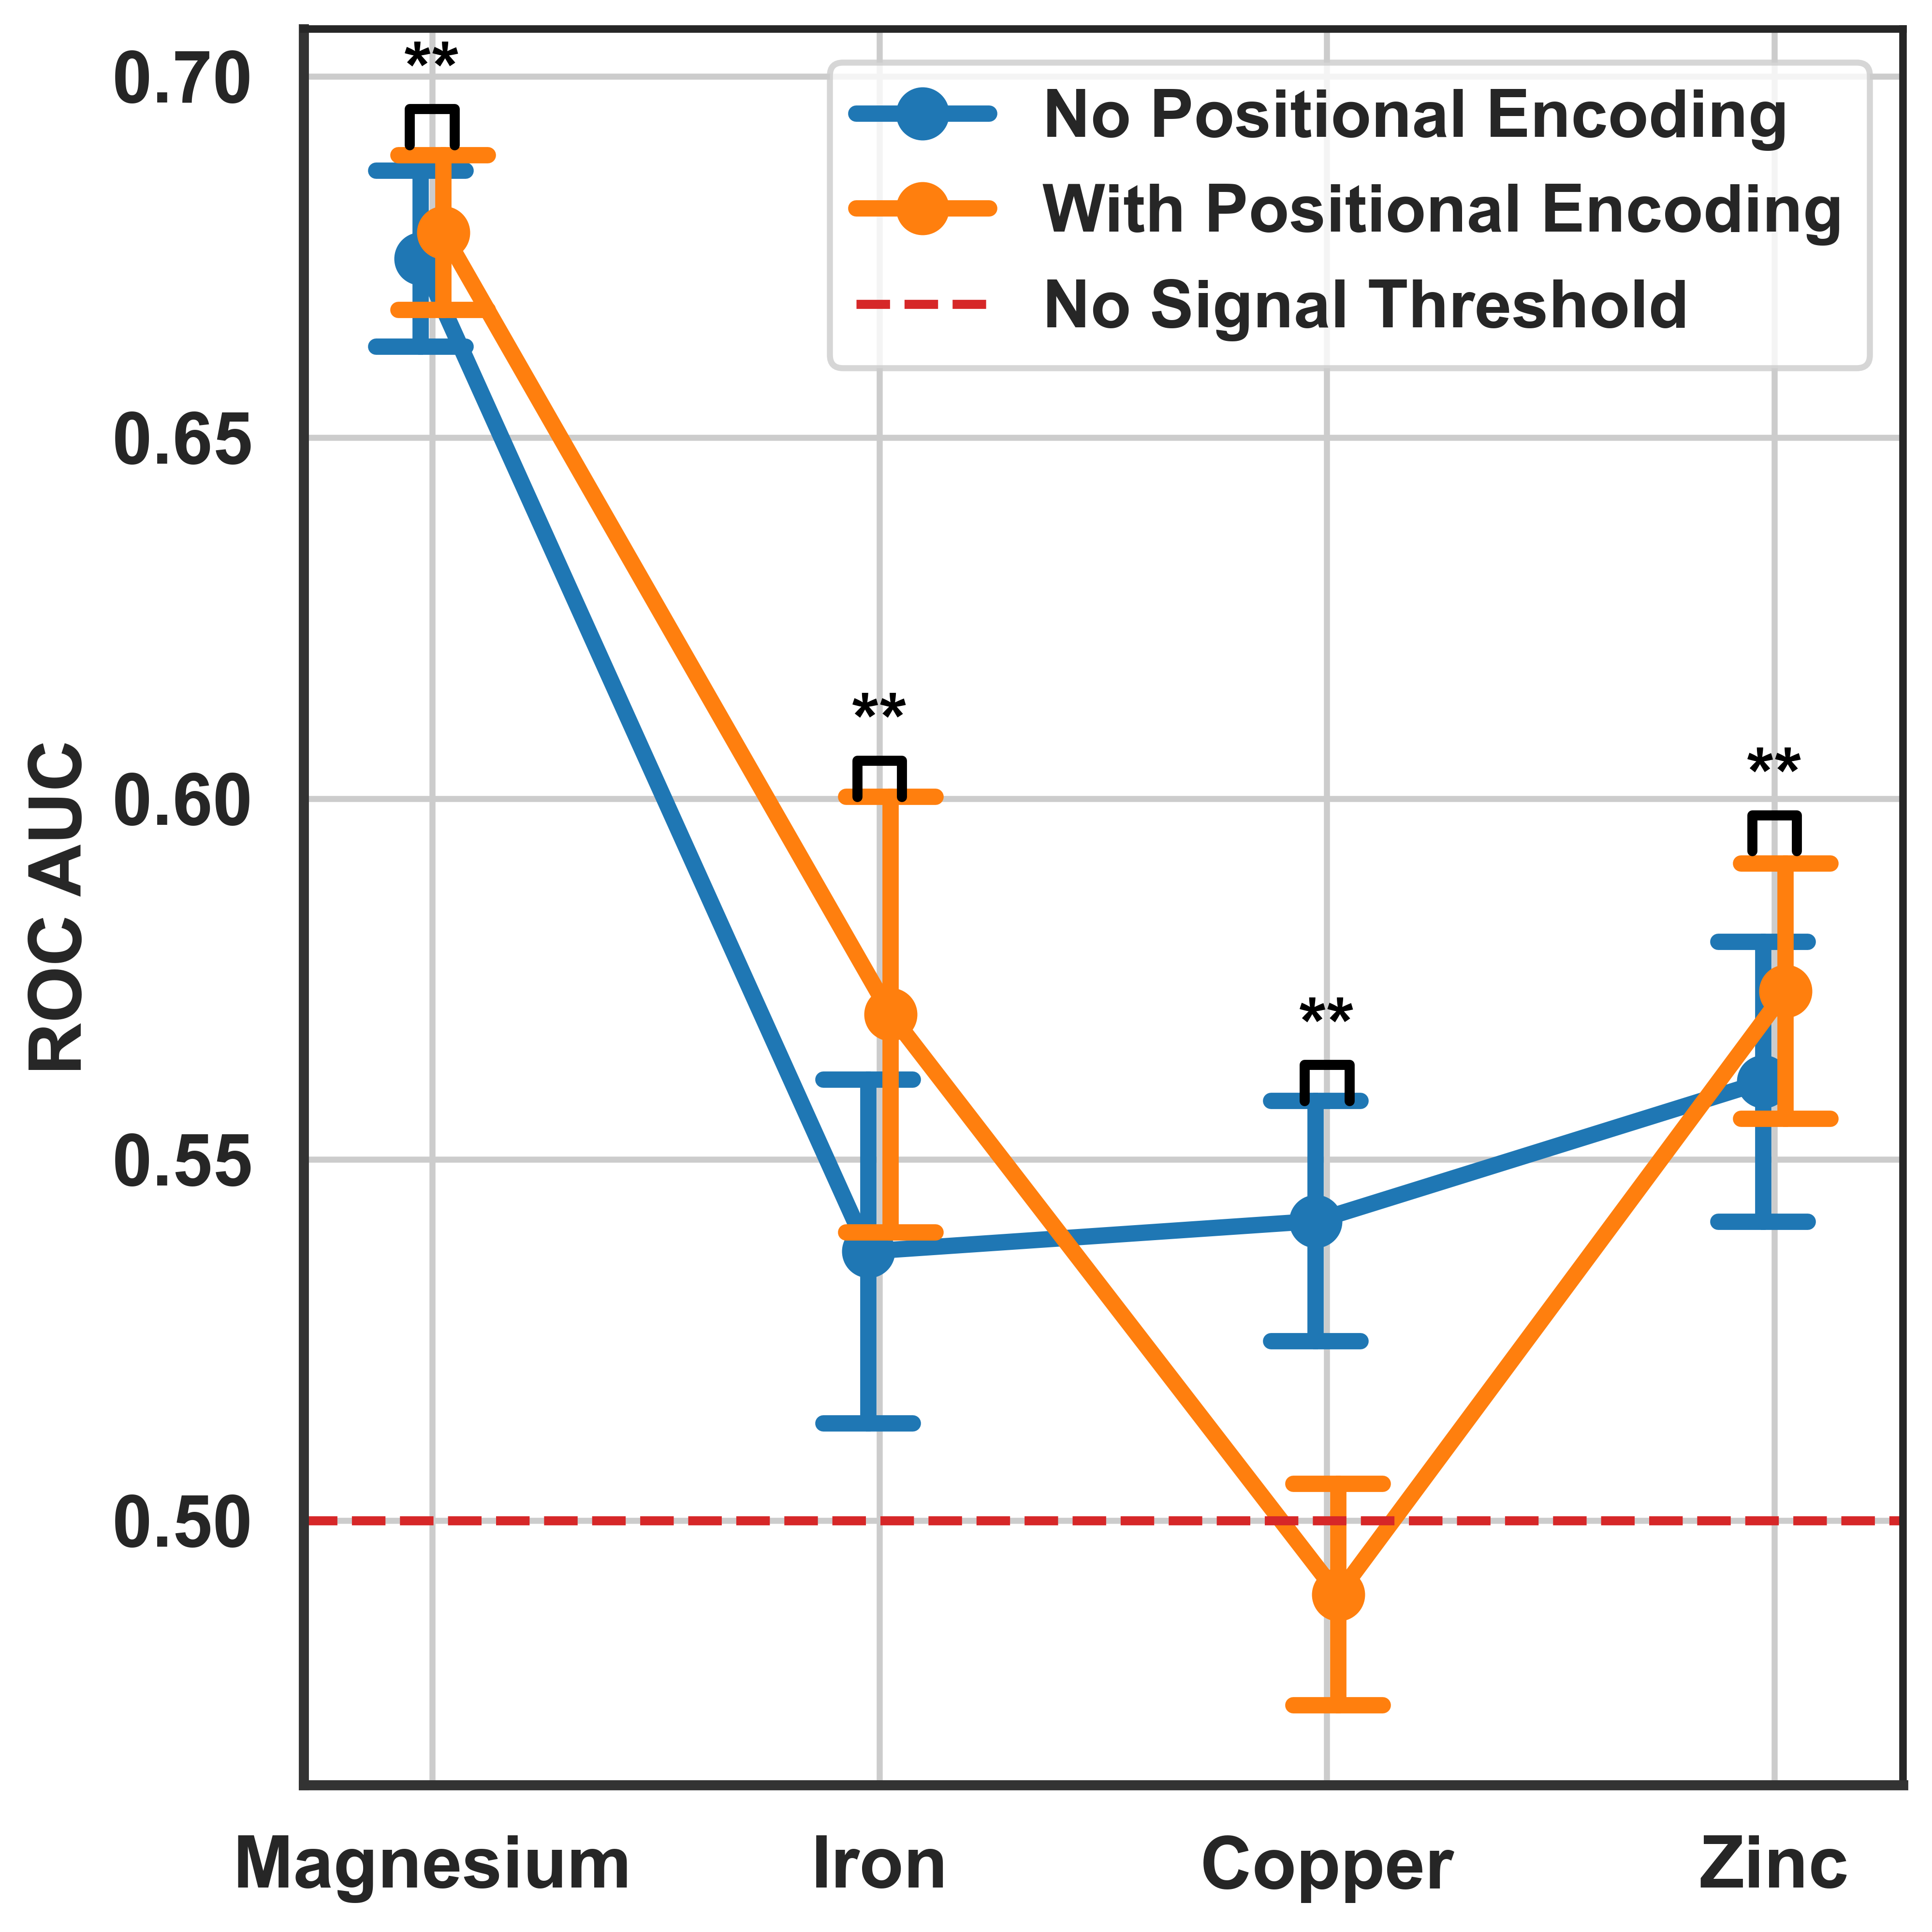

In [24]:
def analyze():
    model_seeds = [
        11, 19, 21, 22, 31, 36, 38, 54, 67, 82, 85, 88, 92, 94, 96, 112, 116, 140, 148, 156,
        161, 177, 178, 212, 223, 225, 240, 242, 249, 276, 289, 293, 294, 300, 306, 309, 311,
        320, 338, 342, 349, 358, 372, 373, 374, 382, 395, 418, 440, 444, 445, 465, 479, 480,
        492, 494, 526, 567, 569, 586, 596, 600, 602, 606, 620, 633, 637, 641, 645, 647, 664,
        689, 697, 708, 748, 753, 777, 794, 804, 812, 828, 831, 843, 858, 861, 875, 889, 891,
        894, 897, 904, 917, 947, 962, 982, 983, 985, 987, 990, 998
    ]
    
    hist_size = 20
    percentile = 0.8
    stats = {
        'is-postional': [],
        'auc': [],
        'metal': [],
    }
    for metal in ['magnesium', 'iron', 'copper', 'zinc']:
        experiment_path = os.path.join(
            experiments_results_dir, 'baseline_cv_train_eval', 
            f'histogram-size-{hist_size}', f'p-{percentile}', 'all-cores'
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        stats['auc'] += aucs
        stats['is-postional'] += ['No Positional Encoding'] * len(aucs)
        stats['metal'] += [metal.title()] * len(aucs)

        experiment_path = os.path.join(
            experiments_results_dir, 'positional_encoding_cv_train_eval', 
            f'histogram-size-{hist_size}', f'p-{percentile}', 'all-cores'
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        stats['auc'] += aucs
        stats['is-postional'] += ['With Positional Encoding'] * len(aucs)
        stats['metal'] += [metal.title()] * len(aucs)
    stats = pd.DataFrame(stats)
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    default_palette = sns.color_palette()
    sns.pointplot(
        data=stats,
        x='metal',
        y='auc',
        hue='is-postional',
        capsize=0.2,
        dodge=True,
        errorbar='sd',
        ax=ax,
    )
    def significance_bar(start, end, y, display_label):
        size = (ax.get_yticks()[-1] - ax.get_yticks()[-2]) / 10
        h, col = size, 'k'
        ax.plot([start, start, end, end], [y, y+h, y+h, y], lw=2.5, c=col)
        ax.text((start+end)*.5, y+h, display_label, ha='center', va='bottom', color=col, weight='bold')
    
    for i, metal in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
        metal_df = stats[stats['metal'] == metal.title()]
        is_positional = metal_df['is-postional'] == 'With Positional Encoding'
        y = np.max([metal_df.loc[is_positional, 'auc'].mean(), metal_df.loc[~is_positional, 'auc'].mean()]) + np.max([metal_df.loc[is_positional, 'auc'].std(), metal_df.loc[~is_positional, 'auc'].std()])
        _, pval = sp_stats.ttest_ind(metal_df.loc[is_positional, 'auc'], metal_df.loc[~is_positional, 'auc']) 
        if pval < 0.05:
            significance_bar(i-0.05, i+0.05, y, '**')
        else:
            significance_bar(i-0.05, i+0.05, y, 'NS')
    ax.grid()
    ax.axhline(y = 0.5, color = default_palette[3], linestyle = '--', label='No Signal Threshold') 
    ax.set_ylabel('ROC AUC', fontdict={'weight': 'bold'})
    ax.set_xlabel('')
    ax.legend(prop={'weight':'bold'})
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    fig.tight_layout()
    plt.show()
analyze()

# Baseline + Positional Encoding vs Baseline + Positional Encoding + Yeo Johnson

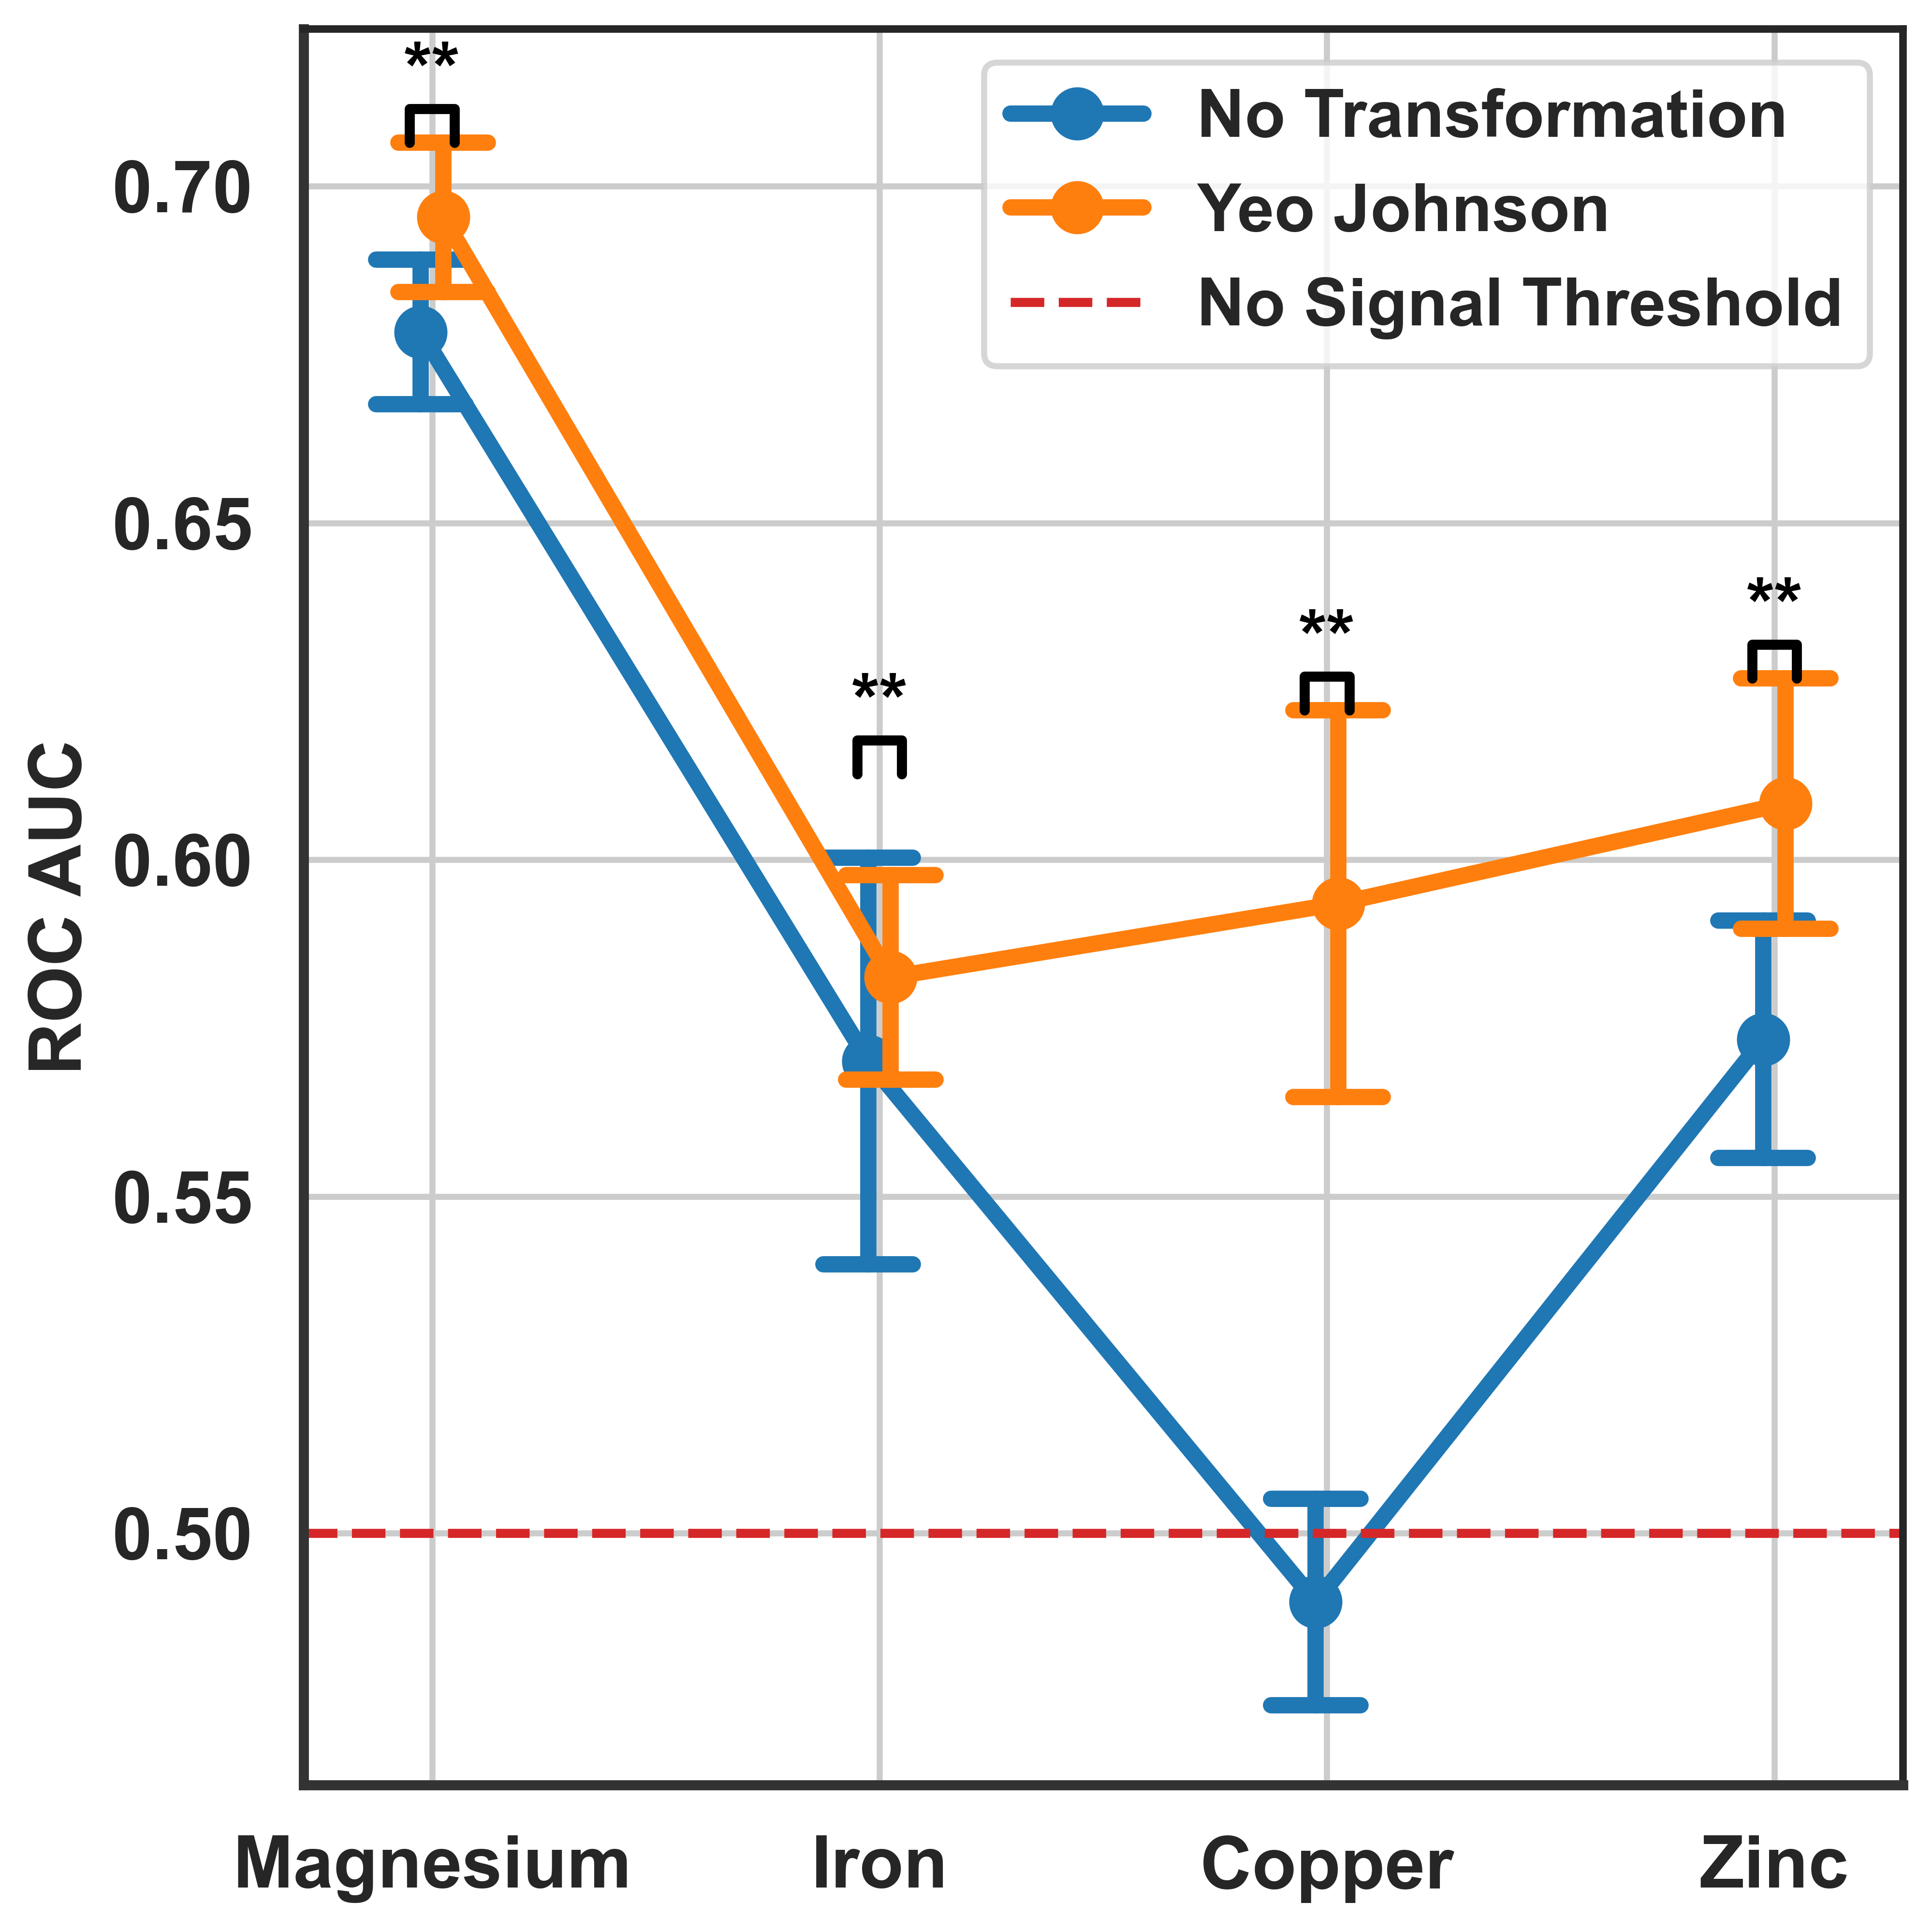

In [27]:
def analyze():
    model_seeds = [
        11, 19, 21, 22, 31, 36, 38, 54, 67, 82, 85, 88, 92, 94, 96, 112, 116, 140, 148, 156,
        161, 177, 178, 212, 223, 225, 240, 242, 249, 276, 289, 293, 294, 300, 306, 309, 311,
        320, 338, 342, 349, 358, 372, 373, 374, 382, 395, 418, 440, 444, 445, 465, 479, 480,
        492, 494, 526, 567, 569, 586, 596, 600, 602, 606, 620, 633, 637, 641, 645, 647, 664,
        689, 697, 708, 748, 753, 777, 794, 804, 812, 828, 831, 843, 858, 861, 875, 889, 891,
        894, 897, 904, 917, 947, 962, 982, 983, 985, 987, 990, 998
    ]
    hist_size = 20
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    stats = {
        'metal': [],
        'is-transform': [],
        'auc': [],
    }
    for metal in ['magnesium', 'iron', 'copper', 'zinc']:
        experiment_path = os.path.join(
            experiments_results_dir, 'positional_encoding_cv_train_eval',
            f'histogram-size-{hist_size}', 'p-0.8', 'all-cores'
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        stats['auc'] += aucs
        stats['is-transform'] += ['No Transformation'] * len(aucs)
        stats['metal'] += [metal.title()] * len(aucs)

        experiment_path = os.path.join(
            experiments_results_dir, 'yeo_johnson_cv_train_eval',
            f'histogram-size-{hist_size}', 'p-0.8', 'all-cores'
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, metal, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        stats['auc'] += aucs
        stats['is-transform'] += ['Yeo Johnson'] * len(aucs)
        stats['metal'] += [metal.title()] * len(aucs)
    stats = pd.DataFrame(stats)
    default_palette = sns.color_palette()
    sns.pointplot(
        data=stats,
        x='metal',
        y='auc',
        hue='is-transform',
        capsize=0.2,
        errorbar='sd',
        dodge=True,
        ax=ax,
    )
    def significance_bar(start, end, y, display_label):
        size = (ax.get_yticks()[-1] - ax.get_yticks()[-2]) / 10
        h, col = size, 'k'
        ax.plot([start, start, end, end], [y, y+h, y+h, y], lw=2.5, c=col)
        ax.text((start+end)*.5, y+h, display_label, ha='center', va='bottom', color=col, weight='bold')
    
    for i, metal in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
        metal_df = stats[stats['metal'] == metal.title()]
        is_transform = metal_df['is-transform'] == 'Yeo Johnson'
        y = np.max([metal_df.loc[is_transform, 'auc'].mean(), metal_df.loc[~is_transform, 'auc'].mean()]) + np.max([metal_df.loc[is_transform, 'auc'].std(), metal_df.loc[~is_transform, 'auc'].std()])
        _, pval = sp_stats.ttest_ind(metal_df.loc[is_transform, 'auc'], metal_df.loc[~is_transform, 'auc']) 
        if pval < 0.05:
            significance_bar(i-0.05, i+0.05, y, '**')
        else:
            significance_bar(i-0.05, i+0.05, y, 'NS')
    ax.grid()
    ax.axhline(y = 0.5, color = default_palette[3], linestyle = '--', label='No Signal Threshold') 
    ax.set_ylabel('ROC AUC', fontdict={'weight': 'bold'})
    ax.set_xlabel('')
    ax.legend(prop={'weight':'bold'})
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    fig.tight_layout()
    plt.show()
analyze()

# Yeo Johnson permutation test

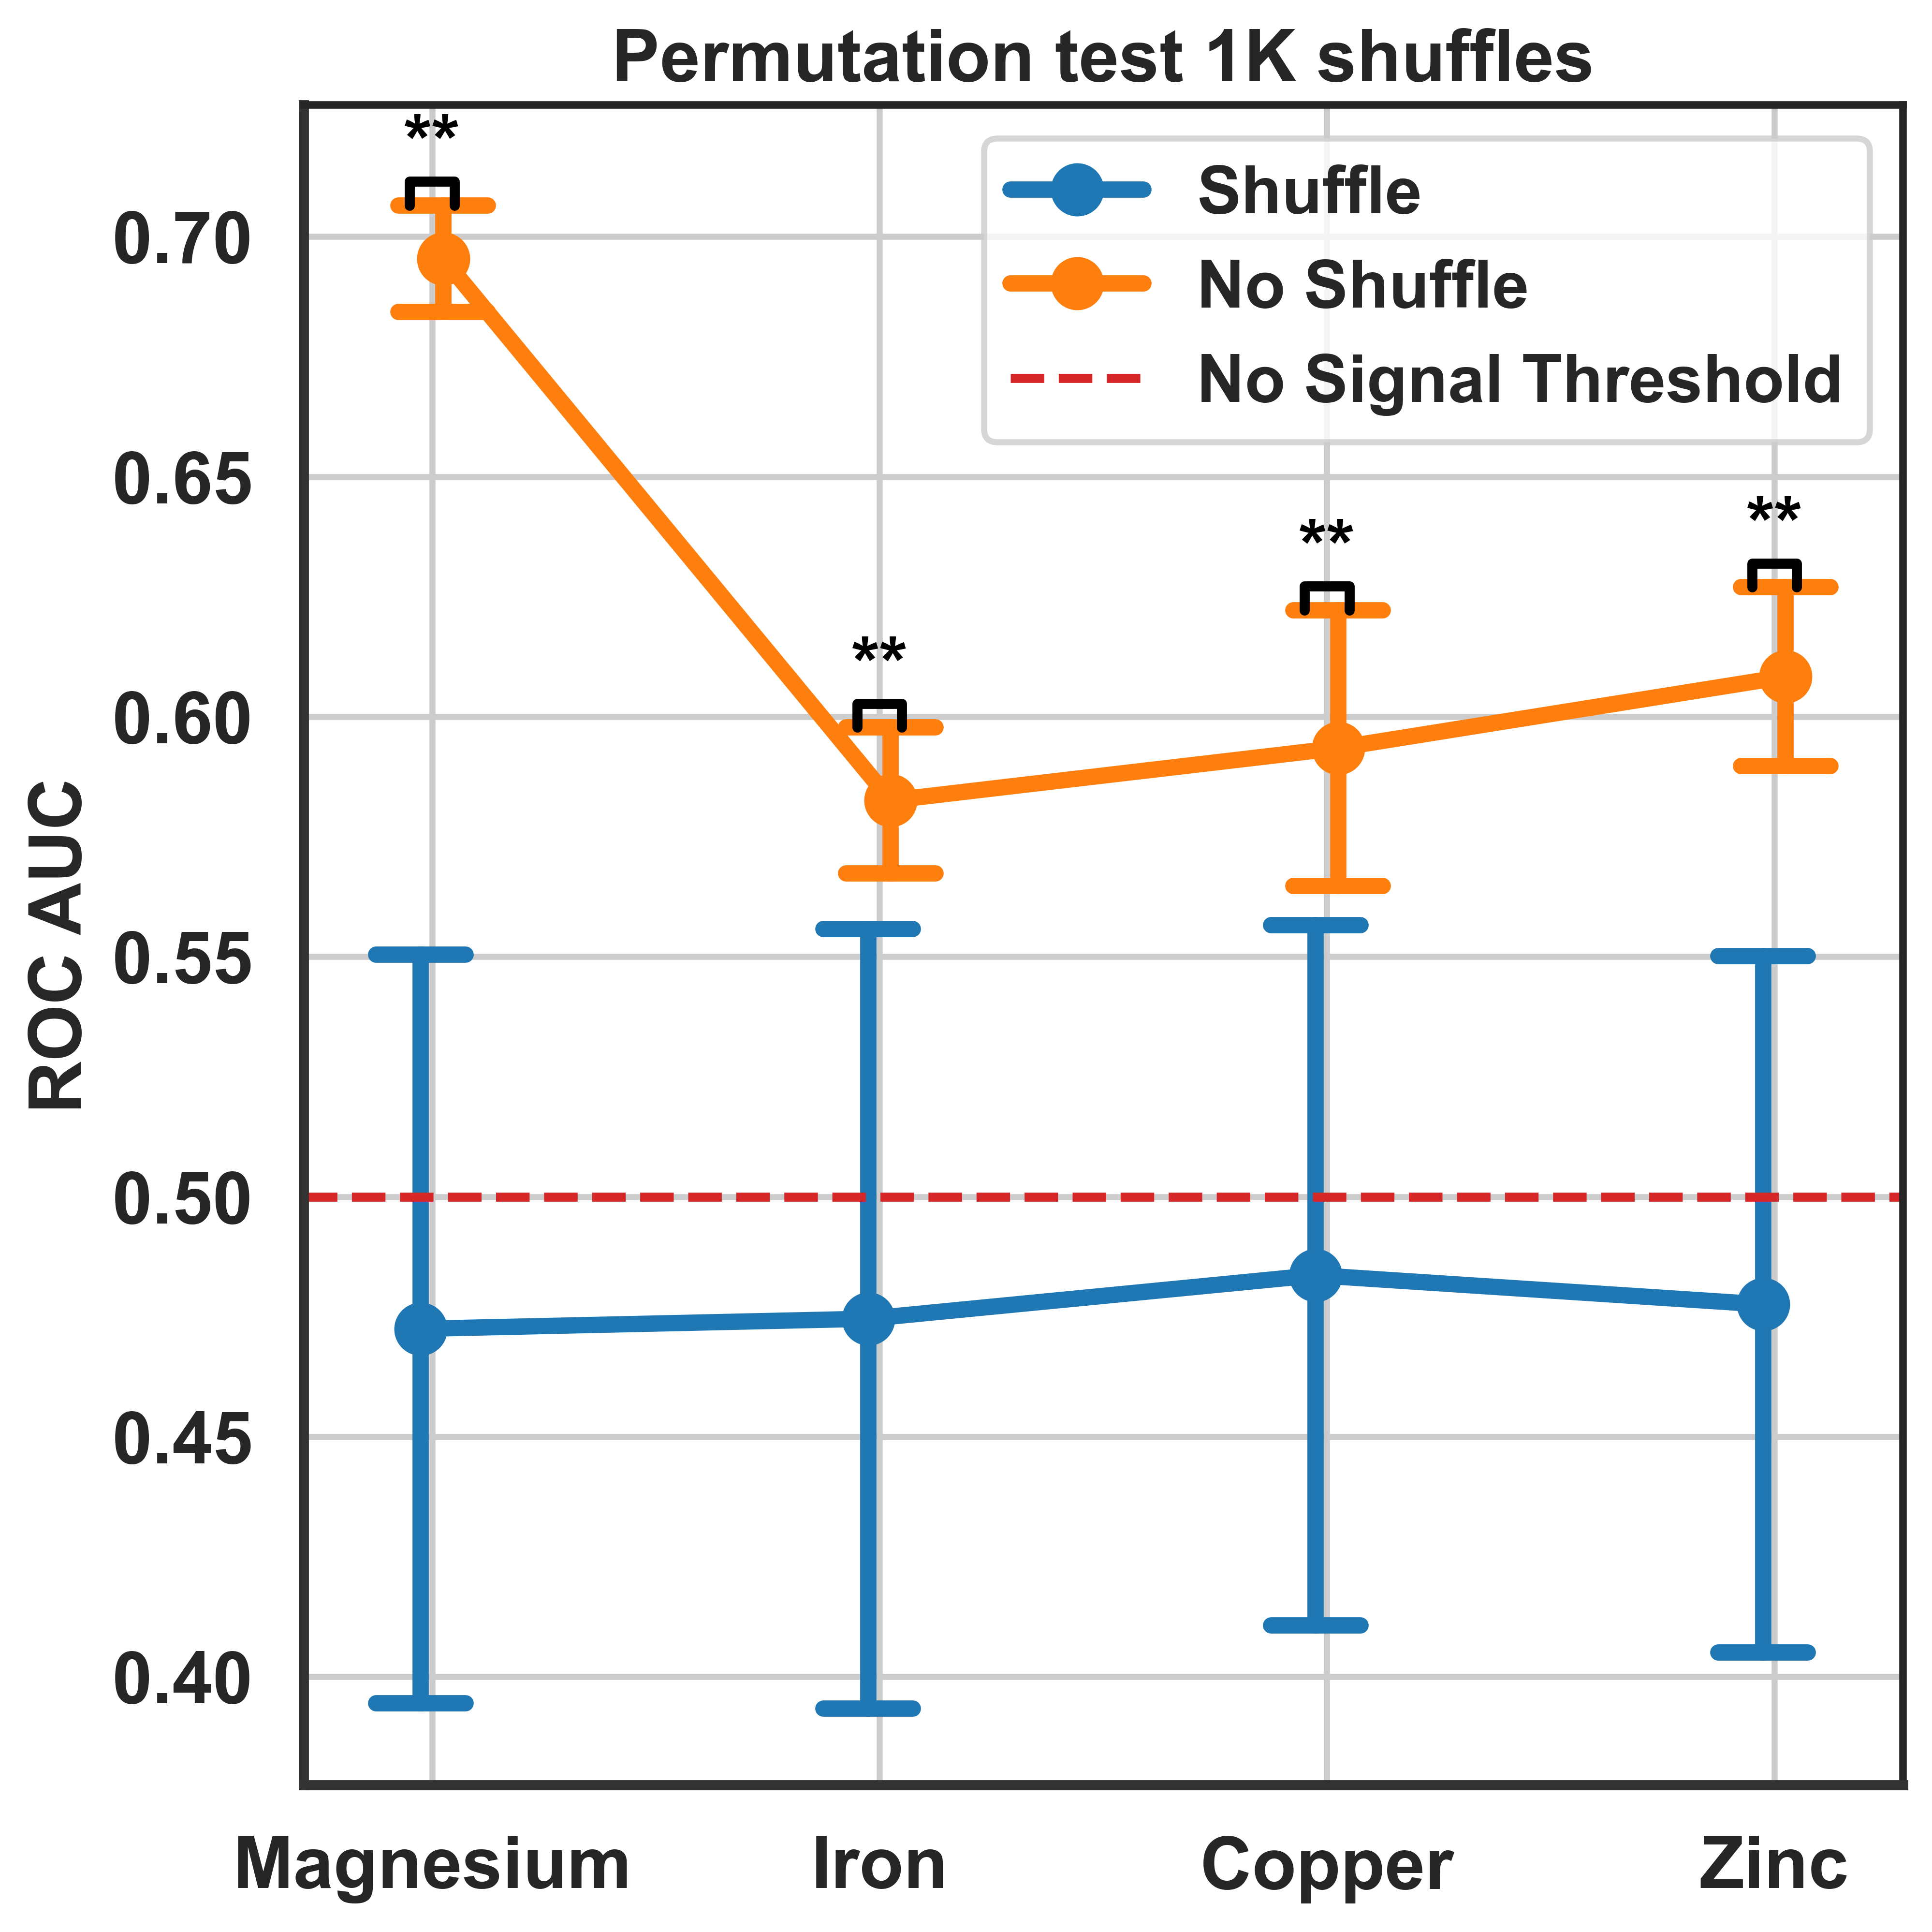

In [29]:
def analyze():
    metal_to_hist_size = {
        'magnesium': 20,
        'iron': 20,
        'copper': 20,
        'zinc': 20,
    }
    df_results = {
        'metal': [],
        'experiment': [],
        'auc': [],
    }
    for metal in ['magnesium', 'iron', 'copper', 'zinc']:
        hist_size = metal_to_hist_size[metal]
        experiment_path = os.path.join(
            experiments_results_dir, 'yeo_johnson_permutation_test_cv_train_eval',
            f'histogram-size-{hist_size}', 'all-cores', metal
        )
        filenames = [filename for filename in os.listdir(experiment_path) if filename.startswith('predictions-seed')]
        permutation_aucs = []
        for filename in filenames:
            csv_filepath = os.path.join(experiment_path, filename)
            df = pd.read_csv(csv_filepath)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            permutation_aucs.append(auc)

        no_permutation_aucs = []
        
        experiment_path = os.path.join(
            experiments_results_dir, 'yeo_johnson_cv_train_eval',
            f'histogram-size-{hist_size}', 'p-0.8', 'all-cores', metal
        )
        for model_seed in [11, 19, 21, 22, 31, 36, 38, 54, 67, 82, 85, 88, 92, 94, 96, 112, 116, 140, 148, 156, 161, 177, 178, 212, 223, 225, 240, 242, 249, 276, 289, 293, 294, 300, 306, 309, 311, 320, 338, 342, 349, 358, 372, 373, 374, 382, 395, 418, 440, 444, 445, 465, 479, 480, 492, 494, 526, 567, 569, 586, 596, 600, 602, 606, 620, 633, 637, 641, 645, 647, 664, 689, 697, 708, 748, 753, 777, 794, 804, 812, 828, 831, 843, 858, 861, 875, 889, 891, 894, 897, 904, 917, 947, 962, 982, 983, 985, 987, 990, 998]:
            csv_filepath = os.path.join(experiment_path, f'predictions-seed-{model_seed}.csv')
            df = pd.read_csv(csv_filepath)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            no_permutation_aucs.append(auc)
        
        df_results['metal'] += [metal.title()] * len(permutation_aucs) + [metal.title()] * len(no_permutation_aucs)
        df_results['experiment'] += ['Shuffle'] * len(permutation_aucs) + ['No Shuffle'] * len(no_permutation_aucs)
        df_results['auc'] += permutation_aucs + no_permutation_aucs
    df_results = pd.DataFrame(df_results)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    sns.pointplot(
        data=df_results,
        x='metal',
        y='auc',
        hue='experiment',
        errorbar='sd',
        capsize=0.2,
        dodge=True,
        ax=ax,
    )
    def significance_bar(start, end, y, display_label):
        size = (ax.get_yticks()[-1] - ax.get_yticks()[-2]) / 10
        # y, h, col = ax.get_yticks()[-2] + size, size, 'k'
        h, col = size, 'k'
        ax.plot([start, start, end, end], [y, y+h, y+h, y], lw=2.5, c=col)
        ax.text((start+end)*.5, y+h, display_label, ha='center', va='bottom', color=col, weight='bold')
    
    for i, metal in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
        metal_df = df_results[df_results['metal'] == metal.title()]
        is_shuffle = metal_df['experiment'] == 'Shuffle'
        y = np.max([metal_df.loc[is_shuffle, 'auc'].mean(), metal_df.loc[~is_shuffle, 'auc'].mean()]) + np.min([metal_df.loc[is_shuffle, 'auc'].std(), metal_df.loc[~is_shuffle, 'auc'].std()])
        _, pval = sp_stats.ttest_ind(metal_df.loc[is_shuffle, 'auc'], metal_df.loc[~is_shuffle, 'auc']) 
        if pval < 0.05:
            significance_bar(i-0.05, i+0.05, y, '**')
        else:
            significance_bar(i-0.05, i+0.05, y, 'NS')
    default_palette = sns.color_palette()
    ax.axhline(y = 0.5, color = default_palette[3], linestyle = '--', label='No Signal Threshold') 
    ax.set_title('Permutation test 1K shuffles', fontdict={'weight': 'bold'})
    ax.set_ylabel('ROC AUC', fontdict={'weight': 'bold'})
    ax.set_xlabel('')
    ax.legend(prop={'weight':'bold'})
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    ax.grid()
    fig.tight_layout()
    plt.show()
analyze()

# 4 Metals classifier

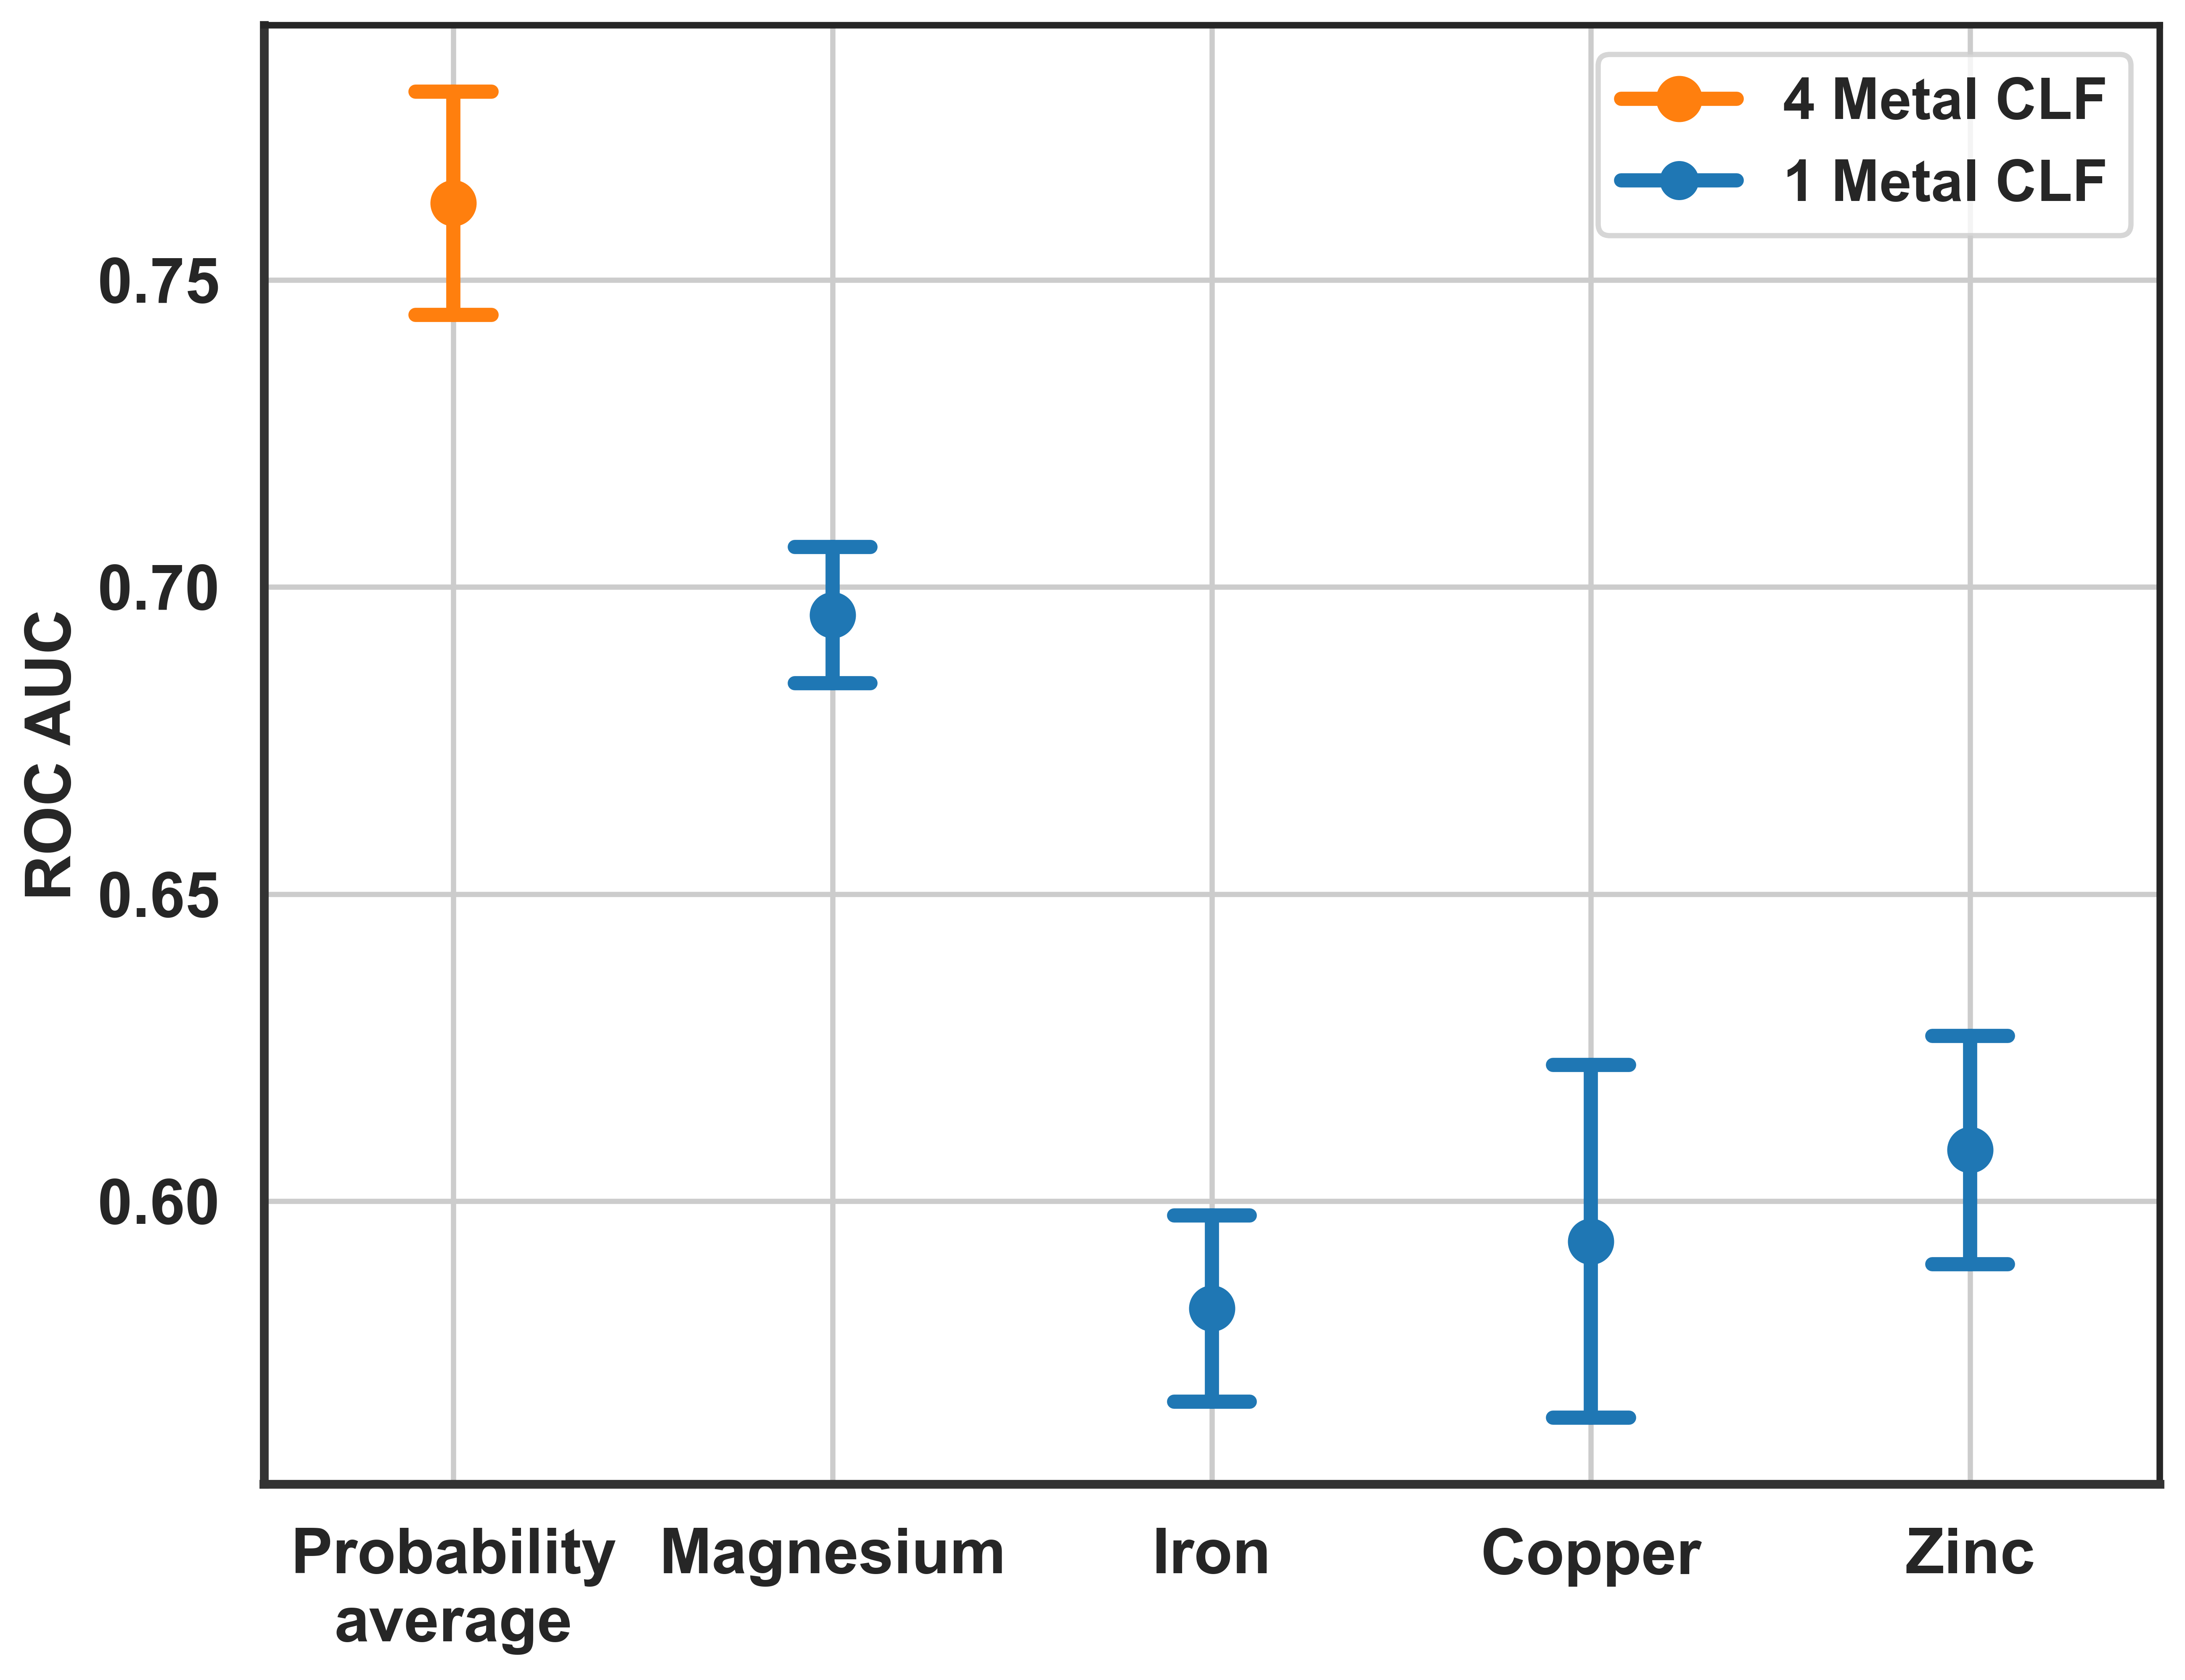

In [ ]:
def temp():
    model_seeds = [
        11, 19, 21, 22, 31, 36, 38, 54, 67, 82, 85, 88, 92, 94, 96, 112, 116, 140, 148, 156,
        161, 177, 178, 212, 223, 225, 240, 242, 249, 276, 289, 293, 294, 300, 306, 309, 311,
        320, 338, 342, 349, 358, 372, 373, 374, 382, 395, 418, 440, 444, 445, 465, 479, 480,
        492, 494, 526, 567, 569, 586, 596, 600, 602, 606, 620, 633, 637, 641, 645, 647, 664,
        689, 697, 708, 748, 753, 777, 794, 804, 812, 828, 831, 843, 858, 861, 875, 889, 891,
        894, 897, 904, 917, 947, 962, 982, 983, 985, 987, 990, 998
    ]
    hist_size = 20
    df_metal = pd.DataFrame()
    for metal in ['magnesium', 'iron', 'copper', 'zinc']:
        experiment_path = os.path.join(
            experiments_results_dir, 'yeo_johnson_cv_train_eval',
            f'histogram-size-{hist_size}', 'p-0.8', 'all-cores', metal
        )
        aucs = []
        for model_seed in model_seeds:
            csv_path = os.path.join(experiment_path, f'predictions-seed-{model_seed}.csv')
            if not os.path.exists(csv_path):
                continue  # Skip if file does not exist
            df = pd.read_csv(csv_path)
            y_true = df['ground-truth'].astype('int32')
            y_scores = df['prediction-proba-1']
            auc = roc_auc_score(y_true, y_scores)
            aucs.append(auc)
        df_metal[f'{metal.title()}'] = aucs
    
    df_metal = df_metal.melt(value_vars=df_metal.columns, var_name='clf', value_name='auc')
    df_metal['clf-type'] = '1 Metal CLF'
    df = pd.read_csv(os.path.join(experiments_results_dir, '4-metals', 'yeo_johnson.csv'))
    df = df.melt(value_vars=df.columns, var_name='clf', value_name='auc')
    df['clf'] = df['clf'].map({
        'probabilities-average': 'Probability\naverage',
    })
    df['clf-type'] = '4 Metal CLF'
    fig, ax = plt.subplots(1, 1, figsize=(9,7))
    default_palette = sns.color_palette()
    sns.pointplot(
        data=df,
        x='clf',
        y='auc',
        hue='clf-type',
        palette=[default_palette[1]],
        errorbar='sd',
        capsize=0.2,
        ax=ax,
    )
    
    palette = [default_palette[0], default_palette[0], default_palette[0], default_palette[0]]
    sns.pointplot(
        data=df_metal,
        x='clf',
        y='auc',
        palette=palette,
        hue='clf',
        errorbar='sd',
        capsize=0.2,
        ax=ax,
    )
    handles, labels = ax.get_legend_handles_labels()
    custom_handle = Line2D([], [], color=default_palette[0], marker='o', linestyle='-', linewidth=4.05, markersize=10.15184451225555, label='1 Metal CLF')

    handles.append(custom_handle)
    labels.append('1 Metal CLF')

    ax.legend(handles, labels, prop={'weight':'bold'})

    ax.set_ylabel('ROC AUC', fontdict={'weight': 'bold'})
    ax.set_xlabel('')
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    ax.grid()
    fig.tight_layout()
    plt.show()
temp()

# We don't remove too much tissue pixels

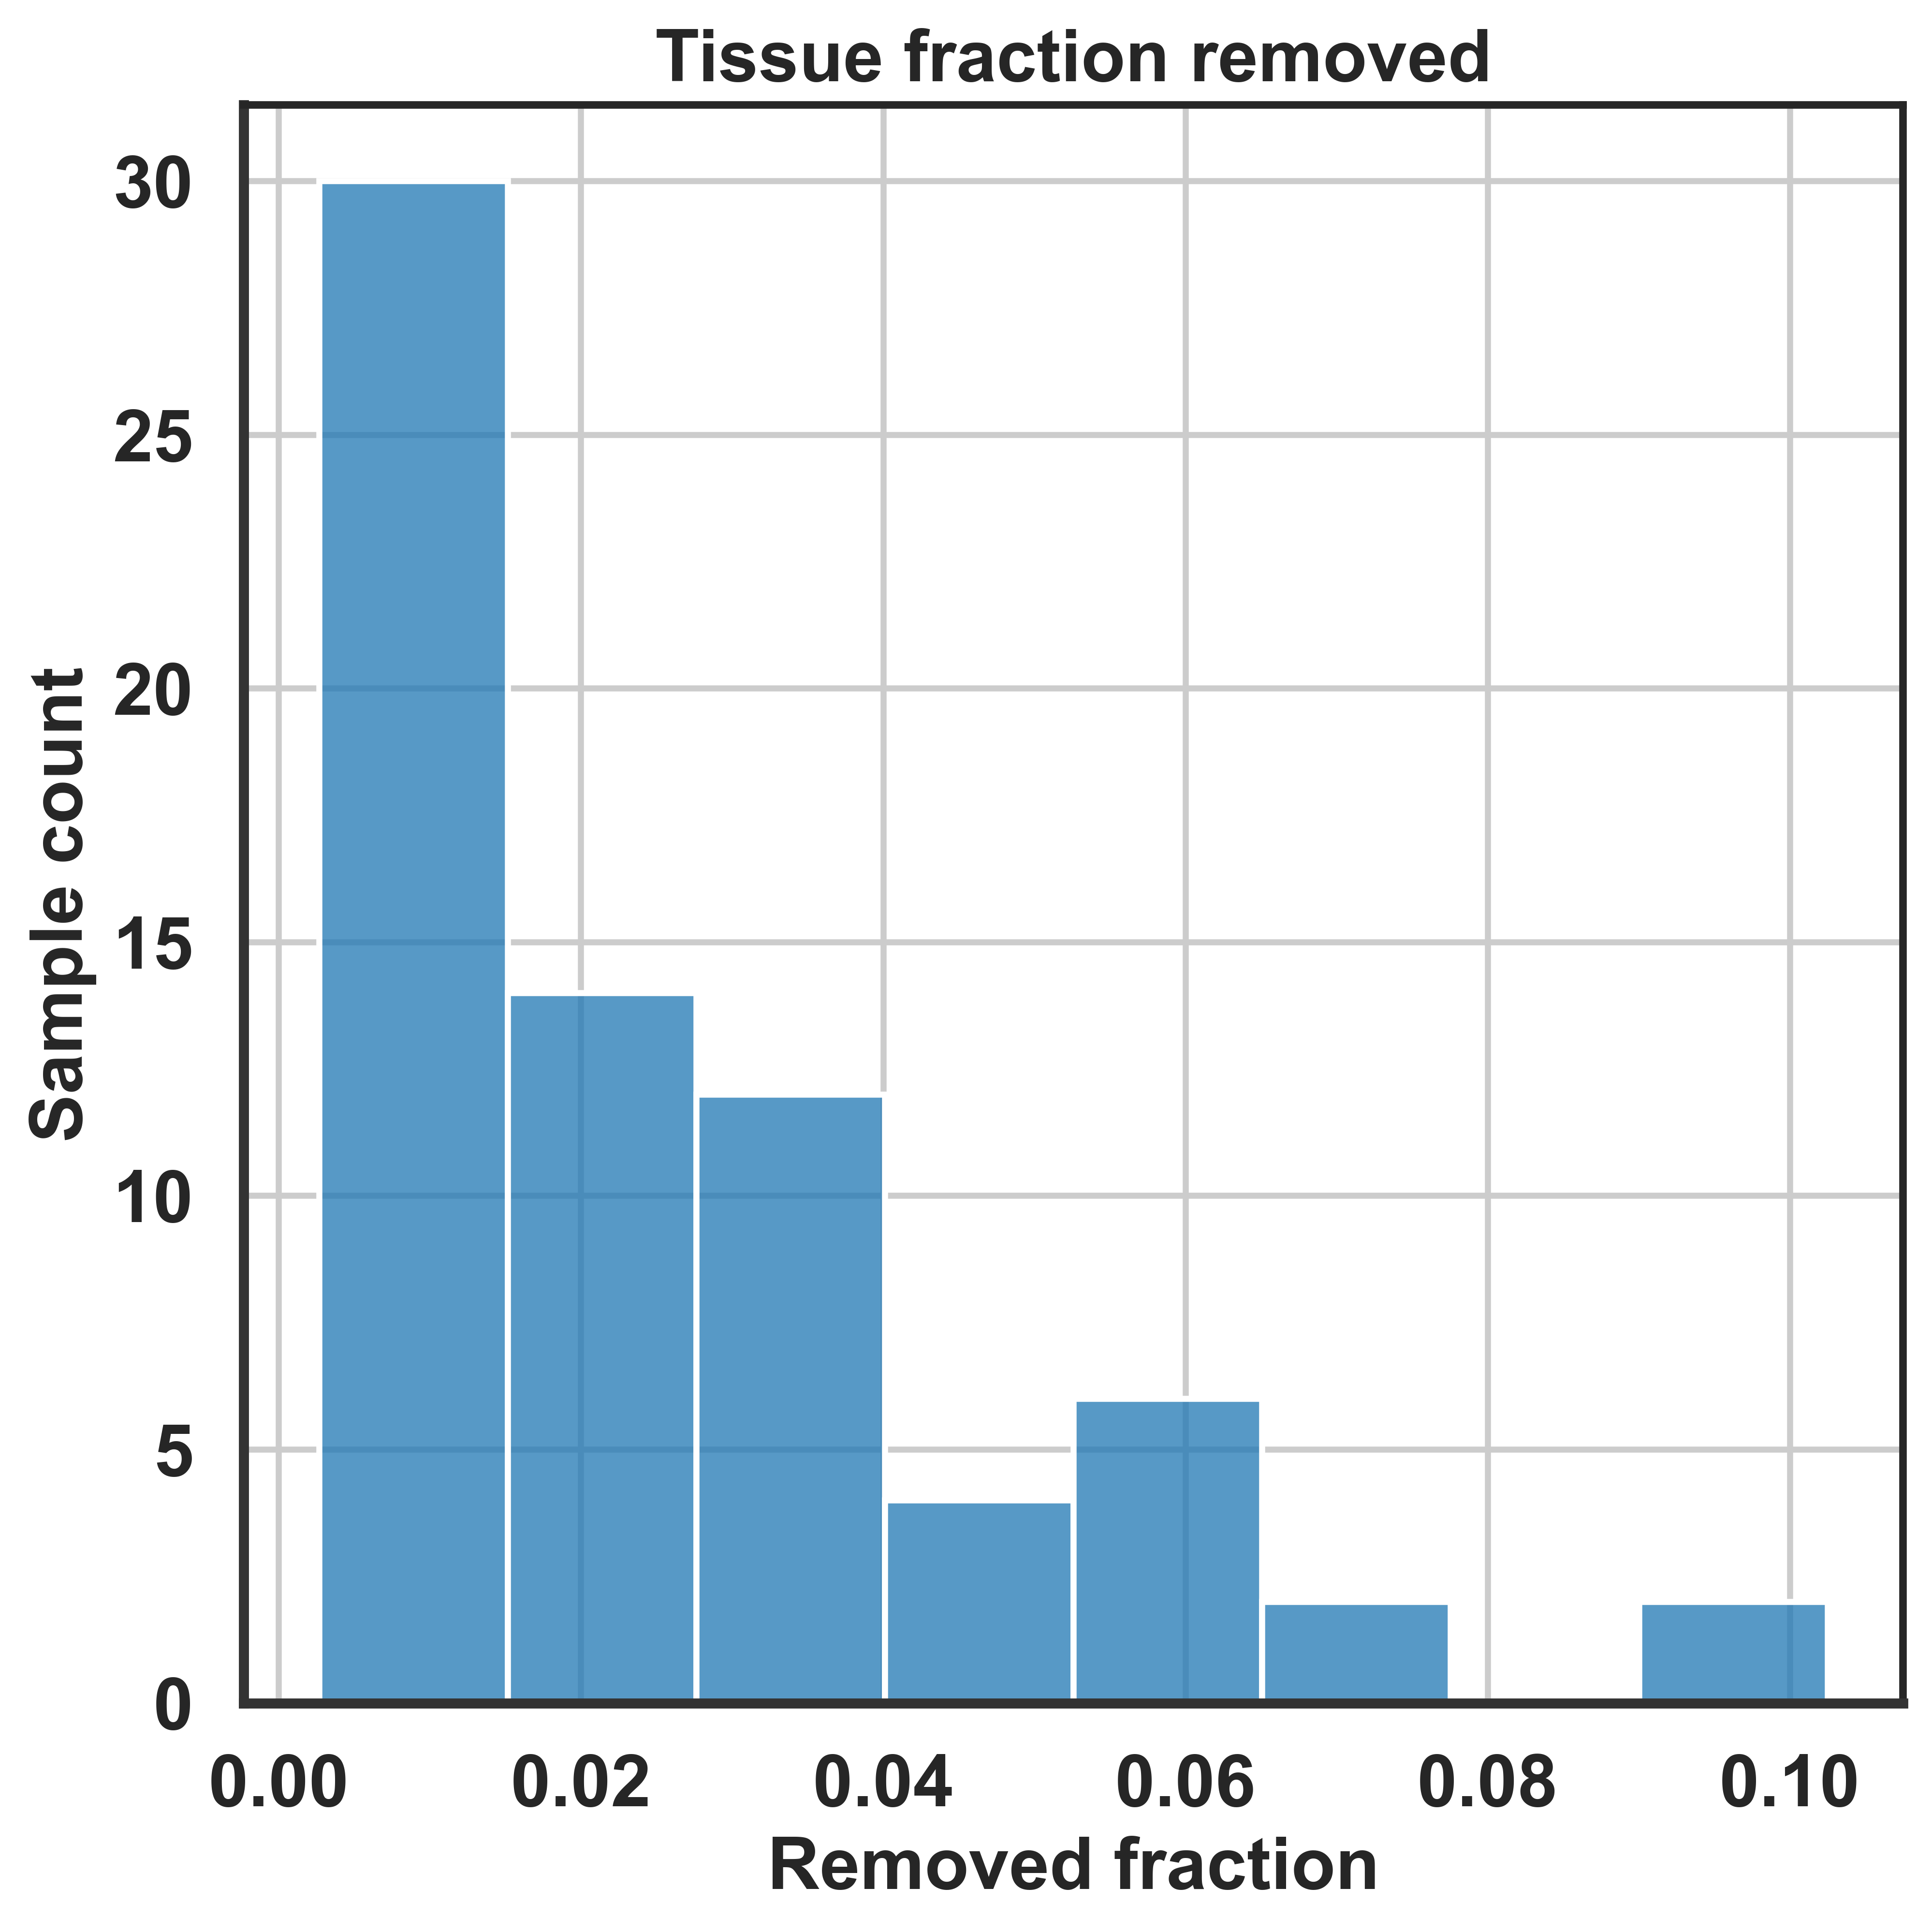

In [39]:
from histogram_representation.min_max_intersection import get_core_pixel_mask

def analyze():
    metal_to_percentile = {
        'magnesium': 0.8,
        'iron': 0.8,
        'copper': 0.8,
        'zinc': 0.8,
    }
    
    fractions = []
    for core in cores_dataset:
        pixel_mask = get_core_pixel_mask(core, metal_to_percentile=metal_to_percentile)
        removed_fraction = 1 - (pixel_mask.sum() / len(pixel_mask))
        fractions.append(removed_fraction)
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    sns.histplot(fractions, ax=ax)
    ax.set_xlabel('Removed fraction', fontdict={'weight': 'bold'})
    ax.set_ylabel('Sample count', fontdict={'weight': 'bold'})
    ax.set_title(f'Tissue fraction removed', fontdict={'weight': 'bold'})
    ax.tick_params(axis ='both', which ='major', labelsize = 18)
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')
    ax.grid()
    fig.tight_layout()
    plt.show()
analyze()

# Histogram as model's input - raw vs log vs yeo johnson

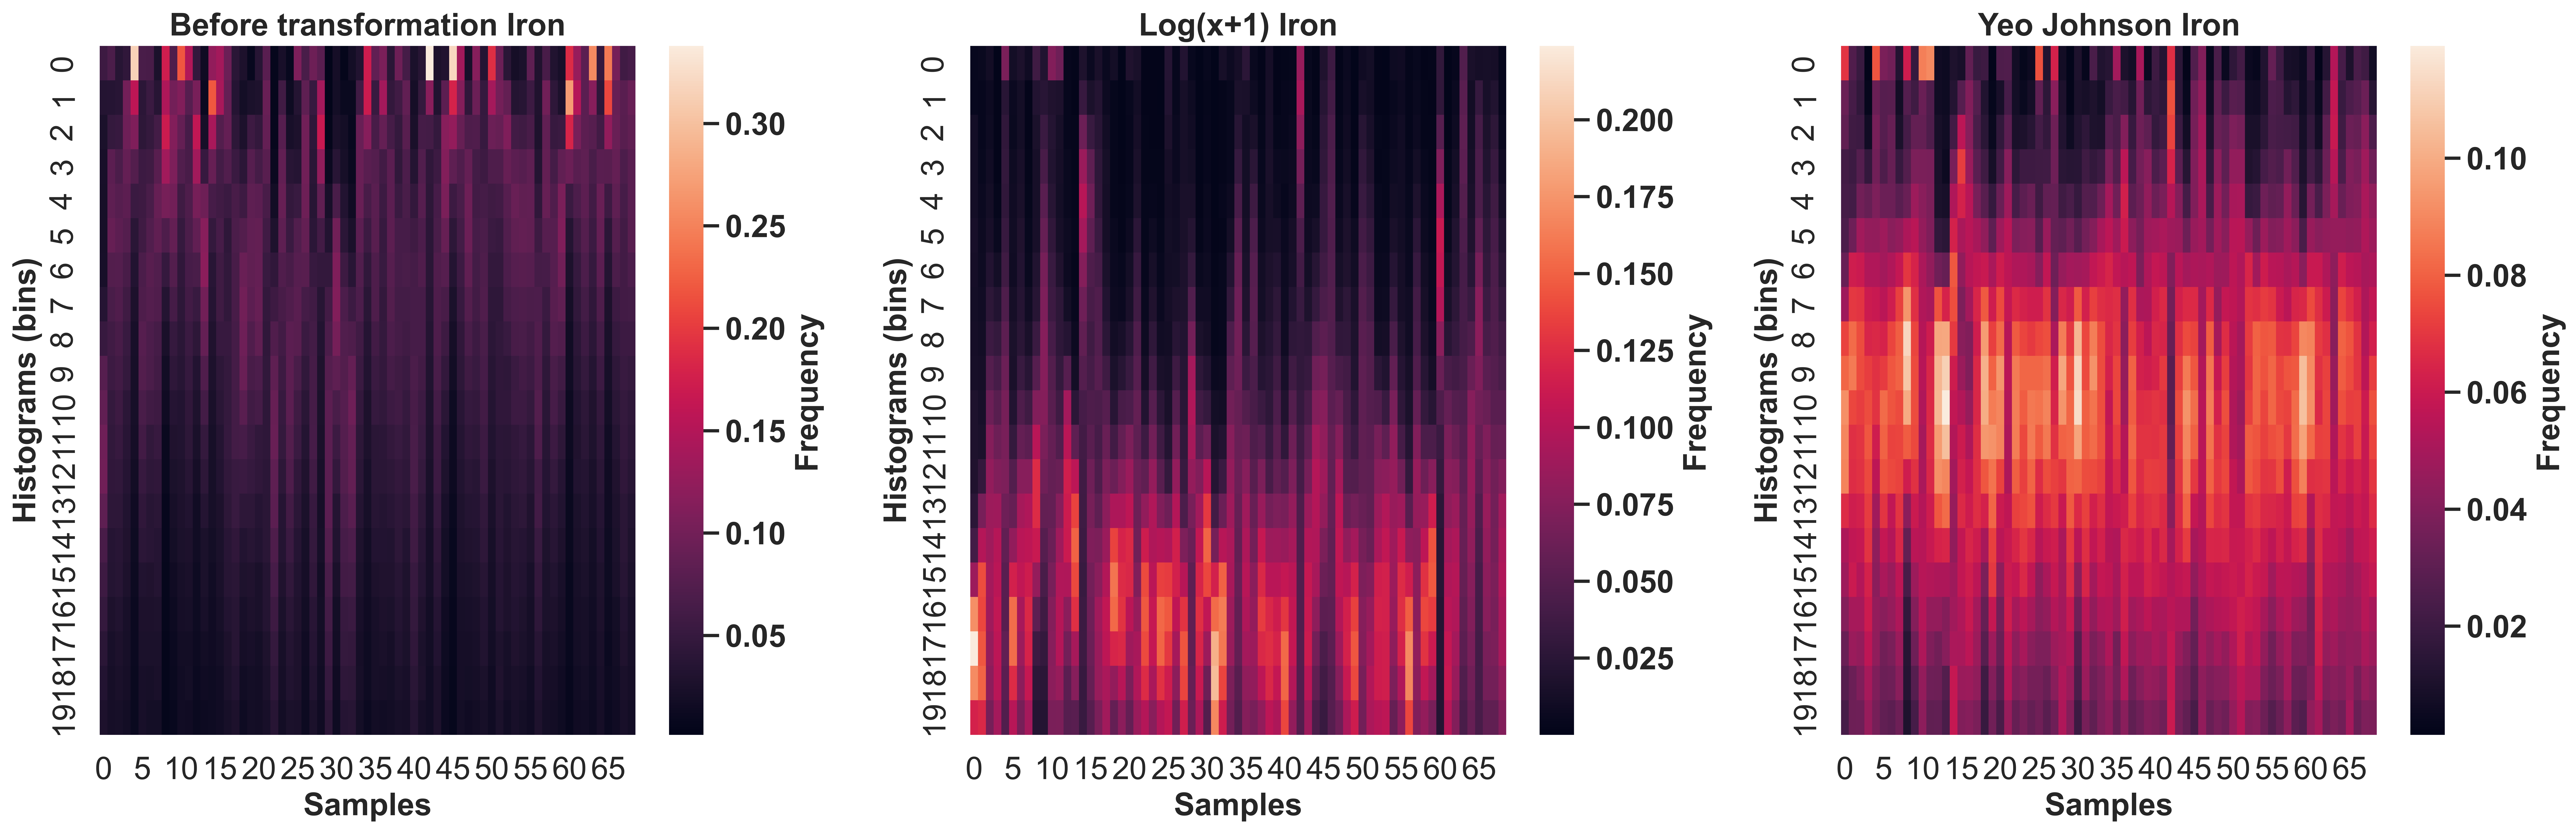

In [53]:
def analyze():
    def get_core_pixel_mask(core, metal: str, metal_to_percentile: dict):
        pixel_mask_lower_outliers = pd.Series([True] * len(core.pixels.index))
        for i, channel in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
            pixels = core.pixels[channel]
            edges = np.histogram_bin_edges(pixels.to_numpy(), bins='fd')
            threshold = edges[1]
            pixel_mask_lower_outliers = pixel_mask_lower_outliers & (pixels <= threshold)
        percentile = metal_to_percentile[metal]
        pixels = core.pixels[metal]
        pixel_mask_upper_outliers = pixels >= pixels.quantile(q=percentile) 
        pixel_mask = (~pixel_mask_upper_outliers) & (~pixel_mask_lower_outliers)
        return pixel_mask

    p = 0.8
    percentiles = {
        'magnesium': p,
        'iron': p,
        'copper': p,
        'zinc': p,
    }
    # for metal in ['magnesium', 'iron', 'copper', 'zinc']:
    for metal in ['iron']:
        src_hists = []
        log_hists = []
        yeo_johnson_hists = []
        for core in cores_dataset:
            pixel_mask = get_core_pixel_mask(core, metal, percentiles)
            core_df = core.pixels.loc[pixel_mask, metal]
            if (core.id + core.chunk_id) == 'Leap095a':
                continue
            all_data_bin_edges = np.histogram_bin_edges(core_df, bins=20)
            pixel_counts = np.histogram(core_df, bins=all_data_bin_edges)[0]
            pixel_sum = pixel_counts.sum()
            hist = pixel_counts / pixel_sum
            hist = np.expand_dims(hist, axis=1)
            src_hists.append(hist)

            core_df_log = np.log(core_df + 1)
            all_data_bin_edges = np.histogram_bin_edges(core_df_log, bins=20)
            pixel_counts = np.histogram(core_df_log, bins=all_data_bin_edges)[0]
            pixel_sum = pixel_counts.sum()
            hist = pixel_counts / pixel_sum
            hist = np.expand_dims(hist, axis=1)
            log_hists.append(hist)
            
            core_df_log = sp_stats.yeojohnson(core_df)[0]
            all_data_bin_edges = np.histogram_bin_edges(core_df_log, bins=20)
            pixel_counts = np.histogram(core_df_log, bins=all_data_bin_edges)[0]
            pixel_sum = pixel_counts.sum()
            hist = pixel_counts / pixel_sum
            hist = np.expand_dims(hist, axis=1)
            yeo_johnson_hists.append(hist)
        src_mat = np.concatenate(src_hists, axis=1)
        log_mat = np.concatenate(log_hists, axis=1)
        yeo_johnson_mat = np.concatenate(yeo_johnson_hists, axis=1)
        vmin = np.min(np.concatenate([log_mat.flatten(), yeo_johnson_mat.flatten()]))
        vmax = np.max(np.concatenate([log_mat.flatten(), yeo_johnson_mat.flatten()]))
        fig, axes = plt.subplots(1, 3, figsize=(21,7))
        # fig, ax = plt.subplots(1, 1, figsize=(21,7))
        ax = axes[0]
        ax.set_title(f'Before transformation {metal.title()}', fontdict={'weight': 'bold'})
        sns.heatmap(
            src_mat,
            cbar_kws={'label': 'Frequency'},
            ax=ax,
        )
        cbar = ax.collections[0].colorbar  # Get the colorbar instance
        cbar.ax.yaxis.label.set_fontweight('bold')  # Set label font weight to bold
        cbar.ax.tick_params(axis='y', which='major', labelsize=18)  # Adjust ticks
        for label in cbar.ax.get_yticklabels():  # Make ticks bold
            label.set_fontweight('bold')

        ax.tick_params(axis ='both', which ='major', labelsize = 18)
        ax.set_xlabel(f'Samples', fontdict={'weight': 'bold'})
        ax.set_ylabel('Histograms (bins)', fontdict={'weight': 'bold'})
        
        ax = axes[1]
        ax.set_title(f'Log(x+1) {metal.title()}', fontdict={'weight': 'bold'})
        sns.heatmap(
            log_mat,
            cbar_kws={'label': 'Frequency'},
            ax=ax,
        )
        cbar = ax.collections[0].colorbar  # Get the colorbar instance
        cbar.ax.yaxis.label.set_fontweight('bold')  # Set label font weight to bold
        cbar.ax.tick_params(axis='y', which='major', labelsize=18)  # Adjust ticks
        for label in cbar.ax.get_yticklabels():  # Make ticks bold
            label.set_fontweight('bold')

        ax.tick_params(axis ='both', which ='major', labelsize = 18)
        ax.set_xlabel(f'Samples', fontdict={'weight': 'bold'})
        ax.set_ylabel('Histograms (bins)', fontdict={'weight': 'bold'})
        
        ax = axes[2]
        ax.set_title(f'Yeo Johnson {metal.title()}', fontdict={'weight': 'bold'})
        sns.heatmap(
            yeo_johnson_mat,
            cbar_kws={'label': 'Frequency'},
            ax=ax,
        )
        cbar = ax.collections[0].colorbar  # Get the colorbar instance
        cbar.ax.yaxis.label.set_fontweight('bold')  # Set label font weight to bold
        cbar.ax.tick_params(axis='y', which='major', labelsize=18)  # Adjust ticks
        for label in cbar.ax.get_yticklabels():  # Make ticks bold
            label.set_fontweight('bold')

        ax.tick_params(axis ='both', which ='major', labelsize = 18)
        ax.set_xlabel(f'Samples', fontdict={'weight': 'bold'})
        ax.set_ylabel('Histograms (bins)', fontdict={'weight': 'bold'})
        
        fig.tight_layout()
        plt.show()
analyze()

# Generate hotspot masks

In [55]:
def no_intersection(core, metal: str, metal_to_percentile: dict):
    percentile = metal_to_percentile[metal]
    pixels = core.pixels[metal]
    pixel_mask_upper_outliers = pixels >= pixels.quantile(q=percentile) 
    return pixel_mask_upper_outliers

def with_intersection(core, metal_to_percentile: dict):
    pixel_mask_upper_outliers = pd.Series([True] * len(core.pixels.index))
    for i, channel in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
        pixels = core.pixels[channel]
        percentile = metal_to_percentile[channel]
        pixel_mask_upper_outliers = pixel_mask_upper_outliers & (pixels >= pixels.quantile(q=percentile)) 
    return pixel_mask_upper_outliers

def get_background(core):
    pixel_mask_lower_outliers = pd.Series([True] * len(core.pixels.index))
    for i, channel in enumerate(['magnesium', 'iron', 'copper', 'zinc']):
        pixels = core.pixels[channel]
        edges = np.histogram_bin_edges(pixels.to_numpy(), bins='fd')
        threshold = edges[1]
        pixel_mask_lower_outliers = pixel_mask_lower_outliers & (pixels <= threshold)
    return pixel_mask_lower_outliers

def analyze():
    p = 0.8
    percentiles = {
        'magnesium': p,
        'iron': p,
        'copper': p,
        'zinc': p,
    }
    for core in tqdm(cores_dataset):
        if core.id + core.chunk_id == 'Leap095a':
            continue
        # fig, axes = plt.subplots(1, 4, figsize=(20,7))
        axes = np.ones(4)
        for ax, metal in zip(axes, ['magnesium', 'iron', 'copper', 'zinc']):
            pixel_mask_no_intersection = no_intersection(core, metal, percentiles)
            pixel_mask_with_intersection = with_intersection(core, percentiles)
            pixel_mask_background = get_background(core)
            pixels_no_info = pixel_mask_no_intersection & (~pixel_mask_with_intersection)
            pixels_metal = core.pixels.loc[pixels_no_info]
            mask = core.mask.copy()
            mask[pixels_metal['y'], pixels_metal['x']] = 2
            if mask.shape[0] * 2 < mask.shape[1]:
                mask = np.rot90(mask)
                # Define the color mapping: 0 -> black, 1 -> white, 2 -> orange
            color_map = {
                0: [0, 0, 0],       # Black (background)
                1: [128, 128, 128], # White (tissue)
                2: [80, 200, 120]    # Orange (outliers)
            }

            # Create a blank RGB image
            height, width = mask.shape
            rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

            # Map the mask values to RGB colors
            for key, color in color_map.items():
                rgb_image[mask == key] = color

            # Save the image as a PNG file
            output_path = f'./hotspot-masks/{core.id + core.chunk_id}-{metal}.png'
            print(f'Saving to {output_path}')
            Image.fromarray(rgb_image).save(output_path)
        #     isns.imshow(mask, vmax=2, cbar=False, ax=ax)
        #     ax.set_title(f'{metal.title()} {core.id + core.chunk_id}', fontdict={'weight': 'bold'})
        # fig.tight_layout()
        # plt.show()
analyze()

  3%|▎         | 2/70 [00:00<00:03, 19.47it/s]

Saving to ./hotspot-masks/Leap001a-magnesium.png
Saving to ./hotspot-masks/Leap001a-iron.png
Saving to ./hotspot-masks/Leap001a-copper.png
Saving to ./hotspot-masks/Leap001a-zinc.png
Saving to ./hotspot-masks/Leap003a-magnesium.png
Saving to ./hotspot-masks/Leap003a-iron.png
Saving to ./hotspot-masks/Leap003a-copper.png
Saving to ./hotspot-masks/Leap003a-zinc.png
Saving to ./hotspot-masks/Leap007a-magnesium.png
Saving to ./hotspot-masks/Leap007a-iron.png
Saving to ./hotspot-masks/Leap007a-copper.png
Saving to ./hotspot-masks/Leap007a-zinc.png
Saving to ./hotspot-masks/Leap008a-magnesium.png
Saving to ./hotspot-masks/Leap008a-iron.png
Saving to ./hotspot-masks/Leap008a-copper.png


  9%|▊         | 6/70 [00:00<00:06,  9.90it/s]

Saving to ./hotspot-masks/Leap008a-zinc.png
Saving to ./hotspot-masks/Leap009a-magnesium.png
Saving to ./hotspot-masks/Leap009a-iron.png
Saving to ./hotspot-masks/Leap009a-copper.png
Saving to ./hotspot-masks/Leap009a-zinc.png
Saving to ./hotspot-masks/Leap011a-magnesium.png
Saving to ./hotspot-masks/Leap011a-iron.png
Saving to ./hotspot-masks/Leap011a-copper.png
Saving to ./hotspot-masks/Leap011a-zinc.png
Saving to ./hotspot-masks/Leap012a-magnesium.png
Saving to ./hotspot-masks/Leap012a-iron.png
Saving to ./hotspot-masks/Leap012a-copper.png
Saving to ./hotspot-masks/Leap012a-zinc.png


 11%|█▏        | 8/70 [00:00<00:05, 11.45it/s]

Saving to ./hotspot-masks/Leap013a-magnesium.png
Saving to ./hotspot-masks/Leap013a-iron.png
Saving to ./hotspot-masks/Leap013a-copper.png
Saving to ./hotspot-masks/Leap013a-zinc.png
Saving to ./hotspot-masks/Leap014a-magnesium.png
Saving to ./hotspot-masks/Leap014a-iron.png
Saving to ./hotspot-masks/Leap014a-copper.png
Saving to ./hotspot-masks/Leap014a-zinc.png
Saving to ./hotspot-masks/Leap015a-magnesium.png


 14%|█▍        | 10/70 [00:01<00:07,  8.52it/s]

Saving to ./hotspot-masks/Leap015a-iron.png
Saving to ./hotspot-masks/Leap015a-copper.png
Saving to ./hotspot-masks/Leap015a-zinc.png
Saving to ./hotspot-masks/Leap017a-magnesium.png


 17%|█▋        | 12/70 [00:01<00:06,  9.06it/s]

Saving to ./hotspot-masks/Leap017a-iron.png
Saving to ./hotspot-masks/Leap017a-copper.png
Saving to ./hotspot-masks/Leap017a-zinc.png
Saving to ./hotspot-masks/Leap017b-magnesium.png
Saving to ./hotspot-masks/Leap017b-iron.png
Saving to ./hotspot-masks/Leap017b-copper.png
Saving to ./hotspot-masks/Leap017b-zinc.png
Saving to ./hotspot-masks/Leap019a-magnesium.png
Saving to ./hotspot-masks/Leap019a-iron.png
Saving to ./hotspot-masks/Leap019a-copper.png


 21%|██▏       | 15/70 [00:01<00:04, 11.43it/s]

Saving to ./hotspot-masks/Leap019a-zinc.png
Saving to ./hotspot-masks/Leap019b-magnesium.png
Saving to ./hotspot-masks/Leap019b-iron.png
Saving to ./hotspot-masks/Leap019b-copper.png
Saving to ./hotspot-masks/Leap019b-zinc.png
Saving to ./hotspot-masks/Leap021a-magnesium.png
Saving to ./hotspot-masks/Leap021a-iron.png
Saving to ./hotspot-masks/Leap021a-copper.png
Saving to ./hotspot-masks/Leap021a-zinc.png
Saving to ./hotspot-masks/Leap021b-magnesium.png
Saving to ./hotspot-masks/Leap021b-iron.png
Saving to ./hotspot-masks/Leap021b-copper.png
Saving to ./hotspot-masks/Leap021b-zinc.png


 27%|██▋       | 19/70 [00:01<00:04, 12.36it/s]

Saving to ./hotspot-masks/Leap023a-magnesium.png
Saving to ./hotspot-masks/Leap023a-iron.png
Saving to ./hotspot-masks/Leap023a-copper.png
Saving to ./hotspot-masks/Leap023a-zinc.png
Saving to ./hotspot-masks/Leap023b-magnesium.png
Saving to ./hotspot-masks/Leap023b-iron.png
Saving to ./hotspot-masks/Leap023b-copper.png
Saving to ./hotspot-masks/Leap023b-zinc.png
Saving to ./hotspot-masks/Leap024a-magnesium.png
Saving to ./hotspot-masks/Leap024a-iron.png
Saving to ./hotspot-masks/Leap024a-copper.png
Saving to ./hotspot-masks/Leap024a-zinc.png


 30%|███       | 21/70 [00:01<00:03, 13.79it/s]

Saving to ./hotspot-masks/Leap026a-magnesium.png
Saving to ./hotspot-masks/Leap026a-iron.png
Saving to ./hotspot-masks/Leap026a-copper.png
Saving to ./hotspot-masks/Leap026a-zinc.png
Saving to ./hotspot-masks/Leap028a-magnesium.png
Saving to ./hotspot-masks/Leap028a-iron.png
Saving to ./hotspot-masks/Leap028a-copper.png
Saving to ./hotspot-masks/Leap028a-zinc.png
Saving to ./hotspot-masks/Leap032a-magnesium.png
Saving to ./hotspot-masks/Leap032a-iron.png
Saving to ./hotspot-masks/Leap032a-copper.png
Saving to ./hotspot-masks/Leap032a-zinc.png
Saving to ./hotspot-masks/Leap034a-magnesium.png


 33%|███▎      | 23/70 [00:02<00:03, 12.72it/s]

Saving to ./hotspot-masks/Leap034a-iron.png
Saving to ./hotspot-masks/Leap034a-copper.png
Saving to ./hotspot-masks/Leap034a-zinc.png
Saving to ./hotspot-masks/Leap036a-magnesium.png
Saving to ./hotspot-masks/Leap036a-iron.png
Saving to ./hotspot-masks/Leap036a-copper.png
Saving to ./hotspot-masks/Leap036a-zinc.png
Saving to ./hotspot-masks/Leap038a-magnesium.png
Saving to ./hotspot-masks/Leap038a-iron.png


 36%|███▌      | 25/70 [00:02<00:03, 11.54it/s]

Saving to ./hotspot-masks/Leap038a-copper.png
Saving to ./hotspot-masks/Leap038a-zinc.png
Saving to ./hotspot-masks/Leap039a-magnesium.png
Saving to ./hotspot-masks/Leap039a-iron.png
Saving to ./hotspot-masks/Leap039a-copper.png
Saving to ./hotspot-masks/Leap039a-zinc.png
Saving to ./hotspot-masks/Leap041a-magnesium.png
Saving to ./hotspot-masks/Leap041a-iron.png
Saving to ./hotspot-masks/Leap041a-copper.png


 41%|████▏     | 29/70 [00:02<00:03, 10.64it/s]

Saving to ./hotspot-masks/Leap041a-zinc.png
Saving to ./hotspot-masks/Leap042a-magnesium.png
Saving to ./hotspot-masks/Leap042a-iron.png
Saving to ./hotspot-masks/Leap042a-copper.png
Saving to ./hotspot-masks/Leap042a-zinc.png
Saving to ./hotspot-masks/Leap043a-magnesium.png
Saving to ./hotspot-masks/Leap043a-iron.png
Saving to ./hotspot-masks/Leap043a-copper.png
Saving to ./hotspot-masks/Leap043a-zinc.png


 44%|████▍     | 31/70 [00:02<00:03, 12.13it/s]

Saving to ./hotspot-masks/Leap044a-magnesium.png
Saving to ./hotspot-masks/Leap044a-iron.png
Saving to ./hotspot-masks/Leap044a-copper.png
Saving to ./hotspot-masks/Leap044a-zinc.png
Saving to ./hotspot-masks/Leap046a-magnesium.png
Saving to ./hotspot-masks/Leap046a-iron.png
Saving to ./hotspot-masks/Leap046a-copper.png
Saving to ./hotspot-masks/Leap046a-zinc.png
Saving to ./hotspot-masks/Leap048a-magnesium.png
Saving to ./hotspot-masks/Leap048a-iron.png
Saving to ./hotspot-masks/Leap048a-copper.png
Saving to ./hotspot-masks/Leap048a-zinc.png
Saving to ./hotspot-masks/Leap050a-magnesium.png
Saving to ./hotspot-masks/Leap050a-iron.png
Saving to ./hotspot-masks/Leap050a-copper.png


 47%|████▋     | 33/70 [00:02<00:02, 13.32it/s]

Saving to ./hotspot-masks/Leap050a-zinc.png
Saving to ./hotspot-masks/Leap064a-magnesium.png
Saving to ./hotspot-masks/Leap064a-iron.png
Saving to ./hotspot-masks/Leap064a-copper.png
Saving to ./hotspot-masks/Leap064a-zinc.png
Saving to ./hotspot-masks/Leap066a-magnesium.png
Saving to ./hotspot-masks/Leap066a-iron.png
Saving to ./hotspot-masks/Leap066a-copper.png


 50%|█████     | 35/70 [00:03<00:02, 11.68it/s]

Saving to ./hotspot-masks/Leap066a-zinc.png
Saving to ./hotspot-masks/Leap067a-magnesium.png
Saving to ./hotspot-masks/Leap067a-iron.png
Saving to ./hotspot-masks/Leap067a-copper.png
Saving to ./hotspot-masks/Leap067a-zinc.png
Saving to ./hotspot-masks/Leap068a-magnesium.png
Saving to ./hotspot-masks/Leap068a-iron.png
Saving to ./hotspot-masks/Leap068a-copper.png
Saving to ./hotspot-masks/Leap068a-zinc.png


 56%|█████▌    | 39/70 [00:03<00:02, 11.61it/s]

Saving to ./hotspot-masks/Leap069a-magnesium.png
Saving to ./hotspot-masks/Leap069a-iron.png
Saving to ./hotspot-masks/Leap069a-copper.png
Saving to ./hotspot-masks/Leap069a-zinc.png
Saving to ./hotspot-masks/Leap071a-magnesium.png
Saving to ./hotspot-masks/Leap071a-iron.png
Saving to ./hotspot-masks/Leap071a-copper.png
Saving to ./hotspot-masks/Leap071a-zinc.png
Saving to ./hotspot-masks/Leap073a-magnesium.png


 59%|█████▊    | 41/70 [00:03<00:02, 11.81it/s]

Saving to ./hotspot-masks/Leap073a-iron.png
Saving to ./hotspot-masks/Leap073a-copper.png
Saving to ./hotspot-masks/Leap073a-zinc.png
Saving to ./hotspot-masks/Leap075a-magnesium.png
Saving to ./hotspot-masks/Leap075a-iron.png
Saving to ./hotspot-masks/Leap075a-copper.png
Saving to ./hotspot-masks/Leap075a-zinc.png
Saving to ./hotspot-masks/Leap076a-magnesium.png
Saving to ./hotspot-masks/Leap076a-iron.png
Saving to ./hotspot-masks/Leap076a-copper.png
Saving to ./hotspot-masks/Leap076a-zinc.png
Saving to ./hotspot-masks/Leap077a-magnesium.png


 61%|██████▏   | 43/70 [00:03<00:02, 10.59it/s]

Saving to ./hotspot-masks/Leap077a-iron.png
Saving to ./hotspot-masks/Leap077a-copper.png
Saving to ./hotspot-masks/Leap077a-zinc.png
Saving to ./hotspot-masks/Leap078a-magnesium.png
Saving to ./hotspot-masks/Leap078a-iron.png
Saving to ./hotspot-masks/Leap078a-copper.png
Saving to ./hotspot-masks/Leap078a-zinc.png
Saving to ./hotspot-masks/Leap080a-magnesium.png
Saving to ./hotspot-masks/Leap080a-iron.png


 64%|██████▍   | 45/70 [00:04<00:02, 11.37it/s]

Saving to ./hotspot-masks/Leap080a-copper.png
Saving to ./hotspot-masks/Leap080a-zinc.png
Saving to ./hotspot-masks/Leap082a-magnesium.png
Saving to ./hotspot-masks/Leap082a-iron.png
Saving to ./hotspot-masks/Leap082a-copper.png
Saving to ./hotspot-masks/Leap082a-zinc.png
Saving to ./hotspot-masks/Leap083a-magnesium.png


 67%|██████▋   | 47/70 [00:04<00:02,  9.54it/s]

Saving to ./hotspot-masks/Leap083a-iron.png
Saving to ./hotspot-masks/Leap083a-copper.png
Saving to ./hotspot-masks/Leap083a-zinc.png
Saving to ./hotspot-masks/Leap084a-magnesium.png
Saving to ./hotspot-masks/Leap084a-iron.png


 70%|███████   | 49/70 [00:04<00:02,  8.83it/s]

Saving to ./hotspot-masks/Leap084a-copper.png
Saving to ./hotspot-masks/Leap084a-zinc.png
Saving to ./hotspot-masks/Leap085a-magnesium.png
Saving to ./hotspot-masks/Leap085a-iron.png
Saving to ./hotspot-masks/Leap085a-copper.png
Saving to ./hotspot-masks/Leap085a-zinc.png
Saving to ./hotspot-masks/Leap086a-magnesium.png
Saving to ./hotspot-masks/Leap086a-iron.png
Saving to ./hotspot-masks/Leap086a-copper.png
Saving to ./hotspot-masks/Leap086a-zinc.png
Saving to ./hotspot-masks/Leap087a-magnesium.png
Saving to ./hotspot-masks/Leap087a-iron.png
Saving to ./hotspot-masks/Leap087a-copper.png
Saving to ./hotspot-masks/Leap087a-zinc.png


 76%|███████▌  | 53/70 [00:05<00:01,  9.38it/s]

Saving to ./hotspot-masks/Leap090a-magnesium.png
Saving to ./hotspot-masks/Leap090a-iron.png
Saving to ./hotspot-masks/Leap090a-copper.png
Saving to ./hotspot-masks/Leap090a-zinc.png
Saving to ./hotspot-masks/Leap091a-magnesium.png
Saving to ./hotspot-masks/Leap091a-iron.png
Saving to ./hotspot-masks/Leap091a-copper.png
Saving to ./hotspot-masks/Leap091a-zinc.png
Saving to ./hotspot-masks/Leap092a-magnesium.png
Saving to ./hotspot-masks/Leap092a-iron.png
Saving to ./hotspot-masks/Leap092a-copper.png
Saving to ./hotspot-masks/Leap092a-zinc.png


 79%|███████▊  | 55/70 [00:05<00:01,  9.07it/s]

Saving to ./hotspot-masks/Leap093a-magnesium.png
Saving to ./hotspot-masks/Leap093a-iron.png
Saving to ./hotspot-masks/Leap093a-copper.png
Saving to ./hotspot-masks/Leap093a-zinc.png
Saving to ./hotspot-masks/Leap103a-magnesium.png
Saving to ./hotspot-masks/Leap103a-iron.png
Saving to ./hotspot-masks/Leap103a-copper.png


 84%|████████▍ | 59/70 [00:05<00:00, 11.65it/s]

Saving to ./hotspot-masks/Leap103a-zinc.png
Saving to ./hotspot-masks/Leap104a-magnesium.png
Saving to ./hotspot-masks/Leap104a-iron.png
Saving to ./hotspot-masks/Leap104a-copper.png
Saving to ./hotspot-masks/Leap104a-zinc.png
Saving to ./hotspot-masks/Leap105a-magnesium.png
Saving to ./hotspot-masks/Leap105a-iron.png
Saving to ./hotspot-masks/Leap105a-copper.png
Saving to ./hotspot-masks/Leap105a-zinc.png
Saving to ./hotspot-masks/Leap106a-magnesium.png
Saving to ./hotspot-masks/Leap106a-iron.png
Saving to ./hotspot-masks/Leap106a-copper.png
Saving to ./hotspot-masks/Leap106a-zinc.png
Saving to ./hotspot-masks/Leap110a-magnesium.png
Saving to ./hotspot-masks/Leap110a-iron.png


 87%|████████▋ | 61/70 [00:05<00:01,  8.87it/s]

Saving to ./hotspot-masks/Leap110a-copper.png
Saving to ./hotspot-masks/Leap110a-zinc.png
Saving to ./hotspot-masks/Leap111a-magnesium.png
Saving to ./hotspot-masks/Leap111a-iron.png
Saving to ./hotspot-masks/Leap111a-copper.png


 90%|█████████ | 63/70 [00:06<00:00,  8.28it/s]

Saving to ./hotspot-masks/Leap111a-zinc.png
Saving to ./hotspot-masks/Leap112a-magnesium.png
Saving to ./hotspot-masks/Leap112a-iron.png
Saving to ./hotspot-masks/Leap112a-copper.png
Saving to ./hotspot-masks/Leap112a-zinc.png
Saving to ./hotspot-masks/Leap122a-magnesium.png
Saving to ./hotspot-masks/Leap122a-iron.png


 91%|█████████▏| 64/70 [00:06<00:00,  7.28it/s]

Saving to ./hotspot-masks/Leap122a-copper.png
Saving to ./hotspot-masks/Leap122a-zinc.png
Saving to ./hotspot-masks/Leap127a-magnesium.png
Saving to ./hotspot-masks/Leap127a-iron.png


 93%|█████████▎| 65/70 [00:06<00:00,  6.53it/s]

Saving to ./hotspot-masks/Leap127a-copper.png
Saving to ./hotspot-masks/Leap127a-zinc.png
Saving to ./hotspot-masks/Leap128a-magnesium.png
Saving to ./hotspot-masks/Leap128a-iron.png
Saving to ./hotspot-masks/Leap128a-copper.png


 94%|█████████▍| 66/70 [00:06<00:00,  6.23it/s]

Saving to ./hotspot-masks/Leap128a-zinc.png
Saving to ./hotspot-masks/Leap132a-magnesium.png
Saving to ./hotspot-masks/Leap132a-iron.png
Saving to ./hotspot-masks/Leap132a-copper.png


 97%|█████████▋| 68/70 [00:07<00:00,  6.31it/s]

Saving to ./hotspot-masks/Leap132a-zinc.png
Saving to ./hotspot-masks/Leap133a-magnesium.png
Saving to ./hotspot-masks/Leap133a-iron.png
Saving to ./hotspot-masks/Leap133a-copper.png
Saving to ./hotspot-masks/Leap133a-zinc.png
Saving to ./hotspot-masks/Leap134a-magnesium.png
Saving to ./hotspot-masks/Leap134a-iron.png


 99%|█████████▊| 69/70 [00:07<00:00,  6.46it/s]

Saving to ./hotspot-masks/Leap134a-copper.png
Saving to ./hotspot-masks/Leap134a-zinc.png
Saving to ./hotspot-masks/Leap135a-magnesium.png
Saving to ./hotspot-masks/Leap135a-iron.png
Saving to ./hotspot-masks/Leap135a-copper.png
Saving to ./hotspot-masks/Leap135a-zinc.png


100%|██████████| 70/70 [00:07<00:00,  9.50it/s]
